<a href="https://colab.research.google.com/github/FuaadBashi/Died-pipeline-COLAB/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch transformers seqeval datasets


import os, json, random
import numpy as np
import torch
from collections import Counter
import torch.nn as nn
from torch.utils.data import Dataset
from collections import Counter
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.utils import resample
from seqeval.metrics import f1_score, classification_report
from datasets import Dataset as HFDataset

!pip install -q torch transformers seqeval datasets

import json, random
import numpy as np
from collections import Counter

from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset

import random
import numpy as np
import torch
import json
from collections import Counter, defaultdict
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                         TrainingArguments, Trainer, EarlyStoppingCallback)
from torch.utils.data import Dataset as TorchDataset
from seqeval.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
# ─── ClinicalBERT Fine-tuning for PHI De-Identification ───────────────────────────────

In [ ]:
# =========================
# ENHANCED ClinicalBERT - LOCATION & PHONE Optimization
# =========================
import random
import numpy as np
import torch
import json
from collections import Counter, defaultdict
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                         TrainingArguments, Trainer, EarlyStoppingCallback)
from torch.utils.data import Dataset as TorchDataset
from seqeval.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1) Enhanced Seed & Device Setup
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3}GB")

# -------------------------
# 2) Load and Validate Data
# -------------------------
def load_and_validate_data(filepath):
    """Load data with validation checks"""
    with open(filepath) as f:
        data = json.load(f)

    valid_data = []
    for i, entry in enumerate(data):
        if len(entry["tokens"]) == len(entry["labels"]):
            valid_data.append(entry)
        else:
            print(f"⚠️ Skipping entry {i}: token-label mismatch")

    return valid_data

train_data = load_and_validate_data('/content/train.json')
val_data = load_and_validate_data('/content/groundtruth.json')
test_data = load_and_validate_data('/content/test.json')

train_tokens = [e["tokens"] for e in train_data]
train_labels = [e["labels"] for e in train_data]
val_tokens = [e["tokens"] for e in val_data]
val_labels = [e["labels"] for e in val_data]
test_tokens = [e["tokens"] for e in test_data]

print(f"✅ Data loaded - Train: {len(train_tokens)} | Val: {len(val_tokens)} | Test: {len(test_tokens)}")

# -------------------------
# 3) Enhanced Label Cleaning
# -------------------------
def clean_and_normalize_labels(labels):
    """Clean labels with detailed tracking"""
    out = []
    changes = defaultdict(int)

    for l in labels:
        if l in ["B-AGE", "I-AGE"]:
            out.append("O")
            changes["AGE_removed"] += 1
        elif l in ["B-DOCTOR", "I-DOCTOR"]:
            out.append(l.replace("DOCTOR", "NAME"))
            changes["DOCTOR_to_NAME"] += 1
        elif l in ["B-PATIENT", "I-PATIENT"]:
            out.append(l.replace("PATIENT", "NAME"))
            changes["PATIENT_to_NAME"] += 1
        else:
            out.append(l)
    return out, changes

# Process labels
total_changes = defaultdict(int)
cleaned_train_labels = []
cleaned_val_labels = []

for labels in train_labels:
    clean_labels, changes = clean_and_normalize_labels(labels)
    cleaned_train_labels.append(clean_labels)
    for k, v in changes.items():
        total_changes[k] += v

for labels in val_labels:
    clean_labels, changes = clean_and_normalize_labels(labels)
    cleaned_val_labels.append(clean_labels)

train_labels = cleaned_train_labels
val_labels = cleaned_val_labels

print("📊 Label cleaning statistics:")
for change, count in total_changes.items():
    print(f"   {change}: {count}")

target_labels = [
    "B-DATE", "I-DATE", "B-HOSPITAL", "I-HOSPITAL", "B-ID", "I-ID",
    "B-LOCATION", "I-LOCATION", "B-NAME", "I-NAME", "B-PHONE", "I-PHONE", "O"
]

label_to_id = {l: i for i, l in enumerate(target_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

# -------------------------
# 4) TARGETED Data Augmentation for LOCATION & PHONE
# -------------------------
def analyze_rare_entities(tokens_list, labels_list):
    """Analyze LOCATION and PHONE entities specifically"""
    entity_stats = defaultdict(lambda: {"count": 0, "samples": [], "contexts": []})

    for sample_idx, (tokens, labels) in enumerate(zip(tokens_list, labels_list)):
        sample_has_location = False
        sample_has_phone = False

        for i, label in enumerate(labels):
            if label != "O":
                entity_type = label[2:] if label.startswith(("B-", "I-")) else label

                if entity_type in ["LOCATION", "PHONE"]:
                    entity_stats[entity_type]["count"] += 1
                    entity_stats[entity_type]["samples"].append(sample_idx)

                    # Capture wider context for rare entities
                    start = max(0, i-5)
                    end = min(len(tokens), i+6)
                    context = " ".join(tokens[start:end])
                    entity_stats[entity_type]["contexts"].append(context)

                    if entity_type == "LOCATION":
                        sample_has_location = True
                    elif entity_type == "PHONE":
                        sample_has_phone = True

        # Track samples containing rare entities
        if sample_has_location:
            entity_stats["LOCATION"]["samples"].append(sample_idx)
        if sample_has_phone:
            entity_stats["PHONE"]["samples"].append(sample_idx)

    return entity_stats

def aggressive_oversample_rare_entities(tokens_list, labels_list, entity_stats):
    """Aggressively oversample LOCATION and PHONE entities"""
    aug_tokens, aug_labels = [], []

    rare_entities = ["LOCATION", "PHONE"]

    for entity in rare_entities:
        if entity not in entity_stats or entity_stats[entity]["count"] == 0:
            print(f"⚠️ No {entity} entities found in training data")
            continue

        unique_samples = list(set(entity_stats[entity]["samples"]))
        current_count = entity_stats[entity]["count"]

        print(f"🎯 Targeting {entity}:")
        print(f"   Current instances: {current_count}")
        print(f"   Samples with {entity}: {len(unique_samples)}")

        if len(unique_samples) == 0:
            continue

        # Extremely aggressive oversampling for rare entities
        target_multiplier = max(20, 100 // len(unique_samples))  # At least 20x, more if very few samples

        print(f"   📈 Oversampling {entity}: {len(unique_samples)} samples × {target_multiplier}")

        # Oversample each unique sample multiple times
        for _ in range(target_multiplier):
            for sample_idx in unique_samples:
                if sample_idx < len(tokens_list):
                    aug_tokens.append(tokens_list[sample_idx])
                    aug_labels.append(labels_list[sample_idx])

    return aug_tokens, aug_labels

# Analyze and oversample rare entities
entity_stats = analyze_rare_entities(train_tokens, train_labels)
print("🔍 Analyzing rare entities...")

for entity in ["LOCATION", "PHONE"]:
    if entity in entity_stats:
        print(f"   {entity}: {entity_stats[entity]['count']} instances")
        if entity_stats[entity]['contexts']:
            print(f"   Sample contexts: {entity_stats[entity]['contexts'][:3]}")

print("\n🚀 Applying aggressive oversampling for LOCATION & PHONE...")
aug_tokens, aug_labels = aggressive_oversample_rare_entities(train_tokens, train_labels, entity_stats)

train_tokens.extend(aug_tokens)
train_labels.extend(aug_labels)

print(f"✅ Aggressive oversampling complete: +{len(aug_tokens)} samples")
print(f"   Total training samples: {len(train_tokens)}")

# -------------------------
# 5) EXTREME Class Weights for Rare Entities
# -------------------------
def calculate_extreme_weights_for_rare(labels_list):
    """Calculate extreme class weights focusing on LOCATION & PHONE"""
    flat_labels = [lbl for seq in labels_list for lbl in seq]
    counts = Counter(flat_labels)
    total = len(flat_labels)

    weights = {}
    for label in target_labels:
        count = counts.get(label, 1)

        if label == "O":
            weights[label] = 0.3  # Moderate O-class reduction
        elif "LOCATION" in label or "PHONE" in label:
            # EXTREME weights for LOCATION and PHONE
            base_weight = total / (len(target_labels) * count)
            weights[label] = min(base_weight * 5.0, 25.0)  # 5x multiplier, cap at 25
            print(f"🎯 Extreme weight for {label}: {weights[label]:.2f}")
        else:
            # Standard weights for other entities
            base_weight = total / (len(target_labels) * count)
            weights[label] = min(base_weight * 1.2, 6.0)

    return weights

# -------------------------
# 6) Enhanced Dataset with Pattern Recognition
# -------------------------
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", use_fast=True)

class EnhancedNERDataset(TorchDataset):
    def __init__(self, tokens, labels, tokenizer, label_to_id, max_len=256):
        self.tokens, self.labels = tokens, labels
        self.tok, self.l2id, self.max_len = tokenizer, label_to_id, max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words, labs = self.tokens[idx], self.labels[idx]

        # Ensure consistency
        min_len = min(len(words), len(labs))
        words = words[:min_len]
        labs = labs[:min_len]

        # Handle long sequences
        if len(words) > self.max_len - 2:
            words = words[:self.max_len - 2]
            labs = labs[:self.max_len - 2]

        # Enhanced encoding for rare entity detection
        enc = self.tok(words, is_split_into_words=True, truncation=True,
                       max_length=self.max_len, padding="max_length")

        # Align labels with subword tokens
        wids = enc.word_ids()
        aligned = []
        prev_wid = None

        for wid in wids:
            if wid is None:
                aligned.append(-100)
            elif wid != prev_wid:
                if wid < len(labs):
                    label = labs[wid]
                    aligned.append(self.l2id.get(label, self.l2id["O"]))
                else:
                    aligned.append(self.l2id["O"])
            else:
                aligned.append(-100)
            prev_wid = wid

        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(aligned, dtype=torch.long)
        }

# -------------------------
# 7) Focal Loss Trainer for Rare Entity Focus
# -------------------------
class FocalLossTrainer(Trainer):
    def __init__(self, class_weights=None, focal_gamma=3.0, label_to_id=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
        self.focal_gamma = focal_gamma  # Higher gamma for harder focus on rare entities
        self.label_to_id = label_to_id or {}

    def focal_loss(self, logits, labels):
        """Enhanced focal loss with extreme focus on rare entities"""
        ce_loss = F.cross_entropy(logits, labels, weight=self.class_weights, reduction='none')
        pt = torch.exp(-ce_loss)

        # Adaptive alpha based on label rarity
        alpha = torch.ones_like(labels, dtype=torch.float)

        # Get rare entity label IDs
        rare_label_ids = [
            self.label_to_id.get("B-LOCATION", -1),
            self.label_to_id.get("I-LOCATION", -1),
            self.label_to_id.get("B-PHONE", -1),
            self.label_to_id.get("I-PHONE", -1)
        ]

        # Apply high alpha for rare entities
        for label_id in rare_label_ids:
            if label_id != -1:  # Valid label ID
                alpha = torch.where(labels == label_id, 0.9, alpha)

        focal_loss = alpha * (1 - pt) ** self.focal_gamma * ce_loss
        return focal_loss.mean()

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Filter active positions
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, logits.size(-1))[active_loss]
        active_labels = labels.view(-1)[active_loss]

        if len(active_labels) == 0:
            return torch.tensor(0.0, requires_grad=True, device=logits.device)

        # Use focal loss for better rare entity detection
        loss = self.focal_loss(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss

# -------------------------
# 8) Enhanced Metrics Tracking
# -------------------------
def compute_enhanced_metrics(p):
    """Enhanced metrics with specific tracking for LOCATION & PHONE"""
    predictions = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids

    true_labels, pred_labels = [], []

    for pred_seq, label_seq in zip(predictions, labels):
        true_seq, pred_seq_clean = [], []

        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                true_seq.append(id_to_label[label])
                pred_seq_clean.append(id_to_label[pred])

        if true_seq:
            true_labels.append(true_seq)
            pred_labels.append(pred_seq_clean)

    if not true_labels:
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    # Overall metrics
    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)

    # Specific metrics for rare entities
    entity_metrics = {}
    for entity in ["LOCATION", "PHONE"]:
        entity_true = []
        entity_pred = []

        for true_seq, pred_seq in zip(true_labels, pred_labels):
            et = [label if entity in label else 'O' for label in true_seq]
            ep = [label if entity in label else 'O' for label in pred_seq]
            entity_true.append(et)
            entity_pred.append(ep)

        try:
            entity_f1 = f1_score(entity_true, entity_pred)
            entity_metrics[f"{entity.lower()}_f1"] = entity_f1
            print(f"📊 {entity} F1 during training: {entity_f1:.4f}")
        except:
            entity_metrics[f"{entity.lower()}_f1"] = 0.0

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        **entity_metrics
    }

# -------------------------
# 9) Enhanced Training Configuration
# -------------------------
def train_enhanced_model():
    """Train with enhanced focus on LOCATION & PHONE"""

    # Calculate extreme weights
    weight_dict = calculate_extreme_weights_for_rare(train_labels)
    class_weights = torch.tensor([weight_dict[label] for label in target_labels],
                               dtype=torch.float).to(device)

    print("\n⚖️ Enhanced class weights (LOCATION & PHONE focus):")
    for label, weight in zip(target_labels, class_weights.cpu().numpy()):
        if "LOCATION" in label or "PHONE" in label:
            print(f"   🎯 {label}: {weight:.2f} (BOOSTED)")
        else:
            print(f"   {label}: {weight:.2f}")

    # Enhanced training arguments
    args = TrainingArguments(
        output_dir="./outputs/clinicalbert_location_phone_enhanced",
        learning_rate=1.5e-5,              # Slightly lower for stability with extreme weights
        per_device_train_batch_size=2,     # Smaller batch for more frequent updates
        gradient_accumulation_steps=8,     # Maintain effective batch size
        per_device_eval_batch_size=4,
        num_train_epochs=12,               # More epochs due to data augmentation
        warmup_ratio=0.15,                 # More warmup for stability
        lr_scheduler_type="cosine_with_restarts",
        weight_decay=0.01,
        max_grad_norm=0.5,                 # Lower grad norm for stability
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=True,
        dataloader_pin_memory=True,
        dataloader_num_workers=2,
        seed=SEED,
        report_to="none",
        logging_steps=50,
        save_total_limit=5,
        eval_accumulation_steps=4,
        prediction_loss_only=False
    )

    # Initialize fresh model
    model = AutoModelForTokenClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        num_labels=len(target_labels),
        id2label=id_to_label,
        label2id=label_to_id,
        hidden_dropout_prob=0.2,          # Slightly higher dropout for regularization
        attention_probs_dropout_prob=0.2
    )

    # Create enhanced datasets
    train_ds = EnhancedNERDataset(train_tokens, train_labels, tokenizer, label_to_id)
    val_ds = EnhancedNERDataset(val_tokens, val_labels, tokenizer, label_to_id)

    # Create focal loss trainer
    trainer = FocalLossTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        compute_metrics=compute_enhanced_metrics,
        class_weights=class_weights,
        focal_gamma=3.0,  # High gamma for extreme focus
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
    )

    print("🚀 Starting LOCATION & PHONE enhanced training...")
    print(f"📊 Enhanced Configuration:")
    print(f"   • Learning rate: 1.5e-5 (stable)")
    print(f"   • Epochs: 12 (extended)")
    print(f"   • Batch size: 2 (frequent updates)")
    print(f"   • Focal loss gamma: 3.0 (extreme focus)")
    print(f"   • LOCATION/PHONE samples: {len(aug_tokens)} additional")

    try:
        train_results = trainer.train()
        trainer.save_model("./outputs/clinicalbert_location_phone_enhanced")

        print("✅ Enhanced training completed successfully!")

        # Final evaluation
        eval_results = trainer.evaluate()

        print(f"\n📈 Enhanced Results:")
        print(f"   • Overall F1: {eval_results.get('eval_f1', 0):.4f}")
        print(f"   • Overall Precision: {eval_results.get('eval_precision', 0):.4f}")
        print(f"   • Overall Recall: {eval_results.get('eval_recall', 0):.4f}")
        print(f"   • LOCATION F1: {eval_results.get('eval_location_f1', 0):.4f}")
        print(f"   • PHONE F1: {eval_results.get('eval_phone_f1', 0):.4f}")

        return trainer, eval_results

    except Exception as e:
        print(f"❌ Enhanced training failed: {str(e)}")
        raise

# -------------------------
# 10) Run Enhanced Training
# -------------------------
if __name__ == "__main__":
    trainer, results = train_enhanced_model()

    print(f"\n🎯 LOCATION & PHONE Enhancement Results:")
    print(f"   📊 Expected improvements in rare entity detection")
    print(f"   🚀 Model saved for enhanced PHI detection capabilities")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 14GB
✅ Data loaded - Train: 669 | Val: 220 | Test: 220
📊 Label cleaning statistics:
   PATIENT_to_NAME: 4887
   DOCTOR_to_NAME: 17090
   AGE_removed: 37
🔍 Analyzing rare entities...
   LOCATION: 873 instances
   Sample contexts: ['social history : lives in me ##rca . drinks g ##inger', 'history : lives in me ##rca . drinks g ##inger brand', ': the patient lives in j ##er by herself . however']
   PHONE: 1387 instances
   Sample contexts: ['##s ; s office , 49 ##5 - 340 ##1 .', '; s office , 49 ##5 - 340 ##1 . goal', 's office , 49 ##5 - 340 ##1 . goal in']

🚀 Applying aggressive oversampling for LOCATION & PHONE...
🎯 Targeting LOCATION:
   Current instances: 873
   Samples with LOCATION: 90
   📈 Oversampling LOCATION: 90 samples × 20
🎯 Targeting PHONE:
   Current instances: 1387
   Samples with PHONE: 148
   📈 Oversampling PHONE: 148 samples × 20
✅ Aggressive oversampling complete: +4760 samples
   Total training samples: 5429
🎯 Extreme 

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting LOCATION & PHONE enhanced training...
📊 Enhanced Configuration:
   • Learning rate: 1.5e-5 (stable)
   • Epochs: 12 (extended)
   • Batch size: 2 (frequent updates)
   • Focal loss gamma: 3.0 (extreme focus)
   • LOCATION/PHONE samples: 4760 additional


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Location F1,Phone F1
1,0.320200,0.247963,0.243951,0.156250,0.556062,0.000000,0.000000
2,0.013300,0.127101,0.747192,0.626815,0.924795,0.071429,0.000000
3,0.008900,0.108626,0.839636,0.754635,0.946217,0.094340,0.000000
4,0.003300,0.106247,0.905976,0.854545,0.963993,0.200000,1.000000
5,0.003700,0.114760,0.890208,0.832013,0.957156,0.109091,0.000000
6,0.001900,0.108779,0.922442,0.881279,0.967639,0.208333,0.000000


📊 LOCATION F1 during training: 0.0000
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.0714
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.0943
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.2000
📊 PHONE F1 during training: 1.0000
📊 LOCATION F1 during training: 0.1091
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.2083
📊 PHONE F1 during training: 0.0000


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Location F1,Phone F1
1,0.320200,0.247963,0.243951,0.156250,0.556062,0.000000,0.000000
2,0.013300,0.127101,0.747192,0.626815,0.924795,0.071429,0.000000
3,0.008900,0.108626,0.839636,0.754635,0.946217,0.094340,0.000000
4,0.003300,0.106247,0.905976,0.854545,0.963993,0.200000,1.000000
5,0.003700,0.114760,0.890208,0.832013,0.957156,0.109091,0.000000
6,0.001900,0.108779,0.922442,0.881279,0.967639,0.208333,0.000000
7,0.001300,0.091952,0.918977,0.875723,0.966727,0.166667,0.000000
8,0.001700,0.085439,0.935059,0.901438,0.971285,0.292683,1.000000
9,0.000200,0.088777,0.938973,0.908742,0.971285,0.210526,1.000000
10,0.000300,0.089095,0.938847,0.907313,0.972653,0.324324,1.000000


📊 LOCATION F1 during training: 0.1667
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.2927
📊 PHONE F1 during training: 1.0000
📊 LOCATION F1 during training: 0.2105
📊 PHONE F1 during training: 1.0000
📊 LOCATION F1 during training: 0.3243
📊 PHONE F1 during training: 1.0000
📊 LOCATION F1 during training: 0.3333
📊 PHONE F1 during training: 0.0000
📊 LOCATION F1 during training: 0.3333
📊 PHONE F1 during training: 0.0000
✅ Enhanced training completed successfully!


📊 LOCATION F1 during training: 0.2105
📊 PHONE F1 during training: 1.0000

📈 Enhanced Results:
   • Overall F1: 0.9390
   • Overall Precision: 0.9087
   • Overall Recall: 0.9713
   • LOCATION F1: 0.2105
   • PHONE F1: 1.0000

🎯 LOCATION & PHONE Enhancement Results:
   📊 Expected improvements in rare entity detection
   🚀 Model saved for enhanced PHI detection capabilities


In [ ]:
# =========================
# FIXED ClinicalBERT Evaluation Suite
# =========================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter, defaultdict
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1) Safe Evaluation Functions (Handle Length Mismatches)
# -------------------------
def safe_sequence_metrics(true_labels, pred_labels):
    """Calculate metrics safely handling sequence length mismatches"""

    # Ensure sequences have same length
    aligned_true = []
    aligned_pred = []

    for true_seq, pred_seq in zip(true_labels, pred_labels):
        min_len = min(len(true_seq), len(pred_seq))
        if min_len > 0:
            aligned_true.append(true_seq[:min_len])
            aligned_pred.append(pred_seq[:min_len])

    if not aligned_true:
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    # Calculate token-level metrics
    all_true_flat = [label for seq in aligned_true for label in seq]
    all_pred_flat = [label for seq in aligned_pred for label in seq]

    # Entity-level metrics (safer approach)
    true_entities = set()
    pred_entities = set()

    for seq_idx, (true_seq, pred_seq) in enumerate(zip(aligned_true, aligned_pred)):
        # Extract entities from true sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(true_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue  # Continue current entity
            else:  # 'O' or different entity
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        # Handle entity at end of sequence
        if current_entity is not None:
            true_entities.add((seq_idx, entity_start, len(true_seq)-1, current_entity))

        # Extract entities from predicted sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(pred_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            pred_entities.add((seq_idx, entity_start, len(pred_seq)-1, current_entity))

    # Calculate metrics
    tp = len(true_entities & pred_entities)
    fp = len(pred_entities - true_entities)
    fn = len(true_entities - pred_entities)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "true_entities": len(true_entities),
        "pred_entities": len(pred_entities),
        "tp": tp,
        "fp": fp,
        "fn": fn
    }

# -------------------------
# 2) Fixed Prediction Function
# -------------------------
def predict_entities_fixed(tokens_list, model, tokenizer, max_len=256):
    """Generate predictions with better alignment"""
    predictions = []

    model.eval()
    with torch.no_grad():
        for tokens in tokens_list:
            try:
                # Limit sequence length
                if len(tokens) > max_len - 2:
                    tokens = tokens[:max_len - 2]

                # Tokenize
                encoding = tokenizer(
                    tokens,
                    is_split_into_words=True,
                    truncation=True,
                    max_length=max_len,
                    padding="max_length",
                    return_tensors="pt"
                )

                # Get word IDs for alignment
                word_ids = encoding.word_ids()

                # Move to device
                device = next(model.parameters()).device
                encoding = {k: v.to(device) for k, v in encoding.items()}

                # Predict
                outputs = model(**encoding)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()[0]

                # Align predictions with original tokens
                aligned_preds = []
                prev_word_id = None

                for i, word_id in enumerate(word_ids):
                    if word_id is None:
                        continue  # Skip special tokens
                    elif word_id != prev_word_id:
                        # First subword of a word
                        if word_id < len(tokens):
                            pred_id = preds[i]
                            pred_label = id_to_label.get(pred_id, "O")
                            aligned_preds.append(pred_label)
                    prev_word_id = word_id

                # Ensure same length as input tokens
                while len(aligned_preds) < len(tokens):
                    aligned_preds.append("O")
                aligned_preds = aligned_preds[:len(tokens)]

                predictions.append(aligned_preds)

            except Exception as e:
                print(f"Error processing sequence: {e}")
                # Fallback: all O labels
                predictions.append(["O"] * len(tokens))

    return predictions

# -------------------------
# 3) Load Model and Data (Fixed Path)
# -------------------------
print("🔄 Loading trained model and tokenizer...")

# Try multiple possible model paths - UPDATED for enhanced model
possible_paths = [
    "./outputs/clinicalbert_location_phone_enhanced",  # NEW enhanced model
    "./outputs/clinicalbert_optimized",                # Previous optimized model
    "./outputs/clinicalbert_max_recall",               # Original model
    "/content/outputs/clinicalbert_location_phone_enhanced",
    "/content/outputs/clinicalbert_optimized",
    "/content/outputs/clinicalbert_max_recall"
]

model = None
model_path = None

try:
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", use_fast=True)
    print("✅ Tokenizer loaded")

    # Try to find the model
    for path in possible_paths:
        try:
            print(f"🔍 Trying to load model from: {path}")
            model = AutoModelForTokenClassification.from_pretrained(path)
            model_path = path
            print(f"✅ Model loaded from: {path}")
            break
        except Exception as e:
            print(f"❌ Failed to load from {path}: {str(e)[:50]}...")
            continue

    if model is None:
        print("❌ Could not find trained model. Please check if training completed successfully.")
        print("💡 Available files in current directory:")
        import os
        if os.path.exists("outputs"):
            print(f"   outputs/ contents: {os.listdir('outputs')}")
        else:
            print("   No outputs/ directory found")
        exit()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print(f"✅ Model ready on {device}")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# Load data
try:
    with open('/content/test.json') as f:
        test_data = json.load(f)
    test_tokens = [entry["tokens"] for entry in test_data]

    with open('/content/groundtruth.json') as f:
        gt_data = json.load(f)
    gt_tokens = [entry["tokens"] for entry in gt_data]
    gt_labels = [entry["labels"] for entry in gt_data]

    print(f"✅ Data loaded: Test={len(test_tokens)}, GT={len(gt_tokens)} samples")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

# Clean labels (same as training)
def clean_and_normalize_labels(labels):
    out = []
    for l in labels:
        if l in ["B-AGE", "I-AGE"]:
            out.append("O")
        elif l in ["B-DOCTOR", "I-DOCTOR"]:
            out.append(l.replace("DOCTOR", "NAME"))
        elif l in ["B-PATIENT", "I-PATIENT"]:
            out.append(l.replace("PATIENT", "NAME"))
        else:
            out.append(l)
    return out

gt_labels_clean = [clean_and_normalize_labels(labels) for labels in gt_labels]

# Label mappings
target_labels = [
    "B-DATE", "I-DATE", "B-HOSPITAL", "I-HOSPITAL", "B-ID", "I-ID",
    "B-LOCATION", "I-LOCATION", "B-NAME", "I-NAME", "B-PHONE", "I-PHONE", "O"
]
label_to_id = {l: i for i, l in enumerate(target_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

# -------------------------
# 4) Generate Predictions with Fixed Function
# -------------------------
print("🔄 Generating predictions...")
gt_predictions = predict_entities_fixed(gt_tokens, model, tokenizer)
print(f"✅ Generated predictions for {len(gt_predictions)} samples")

# -------------------------
# 5) Safe Evaluation
# -------------------------
print("🔄 Evaluating predictions...")
evaluation_results = safe_sequence_metrics(gt_labels_clean, gt_predictions)

# Per-entity evaluation
entity_metrics = {}
entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]

for entity in entities:
    # Filter sequences for this entity
    entity_true = []
    entity_pred = []

    for true_seq, pred_seq in zip(gt_labels_clean, gt_predictions):
        et = [label if entity in label else 'O' for label in true_seq]
        ep = [label if entity in label else 'O' for label in pred_seq]
        entity_true.append(et)
        entity_pred.append(ep)

    entity_result = safe_sequence_metrics(entity_true, entity_pred)
    entity_metrics[entity] = {
        'f1': entity_result['f1'],
        'precision': entity_result['precision'],
        'recall': entity_result['recall']
    }

# -------------------------
# 6) Save Results
# -------------------------
results_data = {
    'model_path': model_path,
    'test_samples': len(gt_tokens),
    'overall_metrics': {
        'f1': evaluation_results['f1'],
        'precision': evaluation_results['precision'],
        'recall': evaluation_results['recall']
    },
    'entity_metrics': entity_metrics,
    'detailed_stats': {
        'true_entities': evaluation_results['true_entities'],
        'pred_entities': evaluation_results['pred_entities'],
        'tp': evaluation_results['tp'],
        'fp': evaluation_results['fp'],
        'fn': evaluation_results['fn']
    },
    'predictions': gt_predictions,
    'true_labels': gt_labels_clean,
    'tokens': gt_tokens
}

# Save results
with open('evaluation_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

# Create entity DataFrame
entity_df = pd.DataFrame(entity_metrics).T
entity_df.to_csv('entity_performance.csv')

print("✅ Results saved successfully!")

# -------------------------
# 7) Print Summary
# -------------------------
print("\n" + "="*60)
print("🎯 EVALUATION RESULTS (FIXED)")
print("="*60)

print(f"\n📊 Overall Performance:")
print(f"   • F1-Score:  {evaluation_results['f1']:.4f}")
print(f"   • Precision: {evaluation_results['precision']:.4f}")
print(f"   • Recall:    {evaluation_results['recall']:.4f}")

print(f"\n📈 Entity Counts:")
print(f"   • True entities found: {evaluation_results['true_entities']}")
print(f"   • Predicted entities: {evaluation_results['pred_entities']}")
print(f"   • True Positives: {evaluation_results['tp']}")
print(f"   • False Positives: {evaluation_results['fp']}")
print(f"   • False Negatives: {evaluation_results['fn']}")

print(f"\n🎯 Entity-Level Performance:")
for entity, metrics in entity_metrics.items():
    print(f"   • {entity:10s}: F1={metrics['f1']:.3f}, P={metrics['precision']:.3f}, R={metrics['recall']:.3f}")

print(f"\n✅ Evaluation completed successfully!")
print(f"📁 Files saved:")
print(f"   • evaluation_results.json")
print(f"   • entity_performance.csv")

🔄 Loading trained model and tokenizer...
✅ Tokenizer loaded
🔍 Trying to load model from: ./outputs/clinicalbert_location_phone_enhanced
✅ Model loaded from: ./outputs/clinicalbert_location_phone_enhanced
✅ Model ready on cuda
✅ Data loaded: Test=220, GT=220 samples
🔄 Generating predictions...
✅ Generated predictions for 220 samples
🔄 Evaluating predictions...
✅ Results saved successfully!

🎯 EVALUATION RESULTS (FIXED)

📊 Overall Performance:
   • F1-Score:  0.8797
   • Precision: 0.9312
   • Recall:    0.8336

📈 Entity Counts:
   • True entities found: 2548
   • Predicted entities: 2281
   • True Positives: 2124
   • False Positives: 157
   • False Negatives: 424

🎯 Entity-Level Performance:
   • DATE      : F1=0.884, P=0.955, R=0.823
   • HOSPITAL  : F1=0.798, P=0.829, R=0.768
   • ID        : F1=0.987, P=0.997, R=0.978
   • LOCATION  : F1=0.186, P=0.250, R=0.148
   • NAME      : F1=0.676, P=0.773, R=0.600
   • PHONE     : F1=0.080, P=1.000, R=0.042

✅ Evaluation completed successfull

In [ ]:
# ===========================
# FIXED MODEL DOWNLOAD CODE
# ===========================

import os
from google.colab import files

print("📦 Preparing ClinicalBERT model for download...")

# Check what files exist in the outputs directory
if os.path.exists('./outputs'):
    print("✅ Found outputs directory")

    # List contents of outputs directory
    print("\n📂 Contents of ./outputs/:")
    for root, dirs, files_list in os.walk('./outputs'):
        level = root.replace('./outputs', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files_list:
            file_size = os.path.getsize(os.path.join(root, file))
            file_size_mb = file_size / (1024 * 1024)
            print(f"{subindent}{file} ({file_size_mb:.1f} MB)")
else:
    print("❌ outputs directory not found")

    # Check for alternative locations
    print("\n🔍 Checking alternative model save locations...")

    # Check current directory
    current_files = [f for f in os.listdir('.') if 'clinicalbert' in f.lower() or 'model' in f.lower()]
    if current_files:
        print(f"✅ Found model files in current directory: {current_files}")

    # Check if trainer saved model elsewhere
    if 'trainer' in globals():
        print(f"✅ Trainer output directory: {trainer.args.output_dir}")
        if os.path.exists(trainer.args.output_dir):
            print("✅ Trainer output directory exists")
        else:
            print("❌ Trainer output directory not found")

# Method 1: Try original path
if os.path.exists('./outputs/clinicalbert'):
    print("\n📦 Creating zip file from ./outputs/clinicalbert...")
    !zip -rq clinicalbert_model.zip ./outputs/clinicalbert

    if os.path.exists('clinicalbert_model.zip'):
        print("✅ Zip file created successfully")

        # Check zip file size
        zip_size = os.path.getsize('clinicalbert_model.zip')
        zip_size_mb = zip_size / (1024 * 1024)
        print(f"📦 Zip file size: {zip_size_mb:.1f} MB")

        # Download the file
        print("⬇️ Starting download...")
        files.download('clinicalbert_model.zip')
        print("✅ Download initiated!")
    else:
        print("❌ Failed to create zip file")

# Method 2: Try trainer output directory
elif 'trainer' in globals() and os.path.exists(trainer.args.output_dir):
    print(f"\n📦 Creating zip file from trainer output: {trainer.args.output_dir}")
    !zip -rq clinicalbert_model.zip {trainer.args.output_dir}

    if os.path.exists('clinicalbert_model.zip'):
        print("✅ Zip file created successfully")

        # Check zip file size
        zip_size = os.path.getsize('clinicalbert_model.zip')
        zip_size_mb = zip_size / (1024 * 1024)
        print(f"📦 Zip file size: {zip_size_mb:.1f} MB")

        # Download the file
        print("⬇️ Starting download...")
        files.download('clinicalbert_model.zip')
        print("✅ Download initiated!")
    else:
        print("❌ Failed to create zip file")

# Method 3: Manual save if trainer exists
elif 'trainer' in globals():
    print("\n💾 Manually saving model files...")

    # Create a directory for the model
    os.makedirs('clinicalbert_manual', exist_ok=True)

    # Save the model and tokenizer
    trainer.save_model('clinicalbert_manual')

    if 'tokenizer' in globals():
        tokenizer.save_pretrained('clinicalbert_manual')
        print("✅ Tokenizer saved")

    # Save additional files
    import json

    # Save label mappings
    if 'id_to_label' in globals():
        with open('clinicalbert_manual/id_to_label.json', 'w') as f:
            json.dump(id_to_label, f, indent=2)
        print("✅ Label mappings saved")

    if 'label_to_id' in globals():
        with open('clinicalbert_manual/label_to_id.json', 'w') as f:
            json.dump(label_to_id, f, indent=2)

    # Save training args
    if hasattr(trainer, 'args'):
        trainer.args.save_to_json('clinicalbert_manual/training_args.json')
        print("✅ Training arguments saved")

    # Create zip file
    print("📦 Creating zip file...")
    !zip -rq clinicalbert_model.zip clinicalbert_manual/

    if os.path.exists('clinicalbert_model.zip'):
        zip_size = os.path.getsize('clinicalbert_model.zip')
        zip_size_mb = zip_size / (1024 * 1024)
        print(f"✅ Zip file created: {zip_size_mb:.1f} MB")

        # Download the file
        print("⬇️ Starting download...")
        files.download('clinicalbert_model.zip')
        print("✅ Download initiated!")
    else:
        print("❌ Failed to create zip file")

else:
    print("❌ No model found to download")
    print("\n🔧 Troubleshooting steps:")
    print("1. Make sure your model training completed successfully")
    print("2. Check if trainer.save_model() was called")
    print("3. Verify the output directory path")
    print("4. Try running: trainer.save_model('./clinicalbert_download')")

print("\n📋 What's included in the model zip:")
print("✅ Model weights (pytorch_model.bin)")
print("✅ Model configuration (config.json)")
print("✅ Tokenizer files")
print("✅ Label mappings (id_to_label.json)")
print("✅ Training arguments")
print("\n🚀 You can load this model later with:")
print("   from transformers import AutoModelForTokenClassification, AutoTokenizer")
print("   model = AutoModelForTokenClassification.from_pretrained('./path_to_unzipped_model')")
print("   tokenizer = AutoTokenizer.from_pretrained('./path_to_unzipped_model')")

In [ ]:
# =========================
# BIOBERT TRAINING FOR PHI DETECTION
# =========================
import random
import numpy as np
import torch
import json
from collections import Counter, defaultdict
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                         TrainingArguments, Trainer, EarlyStoppingCallback)
from torch.utils.data import Dataset as TorchDataset
from seqeval.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

print("🧬 Starting BioBERT Training for PHI Detection")
print("="*60)

# -------------------------
# 1) Setup and Data Loading (Same as previous)
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load and clean data (reuse previous functions)
def load_and_validate_data(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return [entry for entry in data if len(entry["tokens"]) == len(entry["labels"])]

def clean_and_normalize_labels(labels):
    out = []
    for l in labels:
        if l in ["B-AGE", "I-AGE"]:
            out.append("O")
        elif l in ["B-DOCTOR", "I-DOCTOR"]:
            out.append(l.replace("DOCTOR", "NAME"))
        elif l in ["B-PATIENT", "I-PATIENT"]:
            out.append(l.replace("PATIENT", "NAME"))
        else:
            out.append(l)
    return out

# Load data
train_data = load_and_validate_data('/content/train.json')
val_data = load_and_validate_data('/content/groundtruth.json')
test_data = load_and_validate_data('/content/test.json')

train_tokens = [e["tokens"] for e in train_data]
train_labels = [clean_and_normalize_labels(e["labels"]) for e in train_data]
val_tokens = [e["tokens"] for e in val_data]
val_labels = [clean_and_normalize_labels(e["labels"]) for e in val_data]

print(f"✅ Data loaded - Train: {len(train_tokens)} | Val: {len(val_tokens)}")

# Label setup
target_labels = [
    "B-DATE", "I-DATE", "B-HOSPITAL", "I-HOSPITAL", "B-ID", "I-ID",
    "B-LOCATION", "I-LOCATION", "B-NAME", "I-NAME", "B-PHONE", "I-PHONE", "O"
]
label_to_id = {l: i for i, l in enumerate(target_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

# -------------------------
# 2) BioBERT-Specific Enhancements
# -------------------------
def analyze_biobert_suitability(tokens_list, labels_list):
    """Analyze dataset for BioBERT-specific characteristics"""
    print("🔬 Analyzing dataset for BioBERT training...")

    medical_terms = ['patient', 'hospital', 'doctor', 'medical', 'clinic', 'physician',
                    'diagnosis', 'treatment', 'medicine', 'therapy', 'surgery']

    medical_term_count = 0
    total_tokens = 0

    for tokens in tokens_list:
        for token in tokens:
            total_tokens += 1
            if any(term in token.lower() for term in medical_terms):
                medical_term_count += 1

    medical_density = medical_term_count / total_tokens * 100
    print(f"   📊 Medical term density: {medical_density:.2f}%")
    print(f"   🎯 BioBERT advantage: Biomedical vocabulary pre-training")

    return medical_density

medical_density = analyze_biobert_suitability(train_tokens, train_labels)

# -------------------------
# 3) BioBERT Dataset Class
# -------------------------
class BioBERTNERDataset(TorchDataset):
    def __init__(self, tokens, labels, tokenizer, label_to_id, max_len=256):
        self.tokens, self.labels = tokens, labels
        self.tok, self.l2id, self.max_len = tokenizer, label_to_id, max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words, labs = self.tokens[idx], self.labels[idx]

        # Ensure consistency
        min_len = min(len(words), len(labs))
        words = words[:min_len]
        labs = labs[:min_len]

        # Handle long sequences
        if len(words) > self.max_len - 2:
            words = words[:self.max_len - 2]
            labs = labs[:self.max_len - 2]

        # BioBERT tokenization (similar to BERT but with biomedical vocabulary)
        enc = self.tok(words, is_split_into_words=True, truncation=True,
                       max_length=self.max_len, padding="max_length")

        # Align labels with subword tokens
        wids = enc.word_ids()
        aligned = []
        prev_wid = None

        for wid in wids:
            if wid is None:
                aligned.append(-100)
            elif wid != prev_wid:
                if wid < len(labs):
                    label = labs[wid]
                    aligned.append(self.l2id.get(label, self.l2id["O"]))
                else:
                    aligned.append(self.l2id["O"])
            else:
                aligned.append(-100)
            prev_wid = wid

        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(aligned, dtype=torch.long)
        }

# -------------------------
# 4) BioBERT Training Configuration
# -------------------------
def calculate_balanced_weights(labels_list):
    """Calculate balanced class weights for BioBERT"""
    flat_labels = [lbl for seq in labels_list for lbl in seq]
    counts = Counter(flat_labels)
    total = len(flat_labels)

    weights = {}
    for label in target_labels:
        count = counts.get(label, 1)
        if label == "O":
            weights[label] = 0.5
        else:
            base_weight = total / (len(target_labels) * count)
            weights[label] = min(base_weight * 1.5, 8.0)

    return weights

# -------------------------
# 5) BioBERT Metrics
# -------------------------
def compute_biobert_metrics(p):
    """Compute comprehensive metrics for BioBERT"""
    predictions = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids

    true_labels, pred_labels = [], []

    for pred_seq, label_seq in zip(predictions, labels):
        true_seq, pred_seq_clean = [], []
        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                true_seq.append(id_to_label[label])
                pred_seq_clean.append(id_to_label[pred])
        if true_seq:
            true_labels.append(true_seq)
            pred_labels.append(pred_seq_clean)

    if not true_labels:
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)

    return {"f1": f1, "precision": precision, "recall": recall}

# -------------------------
# 6) BioBERT Training
# -------------------------
def train_biobert_model():
    """Train BioBERT for PHI detection"""

    print("\n🧬 Initializing BioBERT...")

    # Load BioBERT tokenizer and model
    model_name = "dmis-lab/biobert-base-cased-v1.1"
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    print(f"✅ BioBERT tokenizer loaded")
    print(f"   Vocab size: {tokenizer.vocab_size}")
    print(f"   Model: {model_name}")

    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(target_labels),
        id2label=id_to_label,
        label2id=label_to_id,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )

    # Calculate class weights
    weight_dict = calculate_balanced_weights(train_labels)
    class_weights = torch.tensor([weight_dict[label] for label in target_labels],
                               dtype=torch.float).to(device)

    print("\n⚖️ BioBERT class weights:")
    for label, weight in zip(target_labels, class_weights.cpu().numpy()):
        if "LOCATION" in label or "PHONE" in label:
            print(f"   🎯 {label}: {weight:.2f}")
        else:
            print(f"   {label}: {weight:.2f}")

    # Create datasets
    train_ds = BioBERTNERDataset(train_tokens, train_labels, tokenizer, label_to_id)
    val_ds = BioBERTNERDataset(val_tokens, val_labels, tokenizer, label_to_id)

    # Training arguments optimized for BioBERT
    args = TrainingArguments(
        output_dir="./outputs/biobert_phi_detection",
        learning_rate=2e-5,                # Standard BERT learning rate
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine_with_restarts",
        weight_decay=0.01,
        max_grad_norm=1.0,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=True,
        dataloader_pin_memory=True,
        dataloader_num_workers=2,
        seed=SEED,
        report_to="none",
        logging_steps=50,
        save_total_limit=3,
        eval_accumulation_steps=4,
        prediction_loss_only=False
    )

    # Custom trainer with class weights
    class BioBERTTrainer(Trainer):
        def __init__(self, class_weights=None, **kwargs):
            super().__init__(**kwargs)
            self.class_weights = class_weights

        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits

            # Filter active positions
            active_loss = labels.view(-1) != -100
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]

            if len(active_labels) == 0:
                return torch.tensor(0.0, requires_grad=True, device=logits.device)

            # Weighted cross-entropy loss
            loss = F.cross_entropy(active_logits, active_labels, weight=self.class_weights)
            return (loss, outputs) if return_outputs else loss

    # Create trainer
    trainer = BioBERTTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        compute_metrics=compute_biobert_metrics,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print("\n🚀 Starting BioBERT training...")
    print(f"📊 Configuration:")
    print(f"   • Model: BioBERT (biomedical pre-trained)")
    print(f"   • Learning rate: 2e-5")
    print(f"   • Epochs: 8")
    print(f"   • Batch size: 4")
    print(f"   • Medical term density: {medical_density:.2f}%")

    try:
        train_results = trainer.train()
        trainer.save_model("./outputs/biobert_phi_detection")

        print("✅ BioBERT training completed successfully!")

        # Final evaluation
        eval_results = trainer.evaluate()

        print(f"\n📈 BioBERT Results:")
        print(f"   • F1-Score: {eval_results.get('eval_f1', 0):.4f}")
        print(f"   • Precision: {eval_results.get('eval_precision', 0):.4f}")
        print(f"   • Recall: {eval_results.get('eval_recall', 0):.4f}")

        # Save results for comparison
        biobert_results = {
            'model': 'BioBERT',
            'model_name': model_name,
            'f1': eval_results.get('eval_f1', 0),
            'precision': eval_results.get('eval_precision', 0),
            'recall': eval_results.get('eval_recall', 0),
            'medical_density': medical_density
        }

        with open('biobert_results.json', 'w') as f:
            json.dump(biobert_results, f, indent=2)

        print(f"\n🧬 BioBERT advantages observed:")
        print(f"   • Biomedical vocabulary alignment")
        print(f"   • PubMed/PMC pre-training benefits")
        print(f"   • Medical terminology understanding")

        return trainer, eval_results

    except Exception as e:
        print(f"❌ BioBERT training failed: {str(e)}")
        raise

# Run BioBERT training
trainer, results = train_biobert_model()

print(f"\n🎯 BioBERT Training Complete!")
print(f"📁 Model saved to: ./outputs/biobert_phi_detection")
print(f"📊 Results saved to: biobert_results.json")

🧬 Starting BioBERT Training for PHI Detection
✅ Using device: cuda
✅ Data loaded - Train: 669 | Val: 220
🔬 Analyzing dataset for BioBERT training...
   📊 Medical term density: 1.47%
   🎯 BioBERT advantage: Biomedical vocabulary pre-training

🧬 Initializing BioBERT...
✅ BioBERT tokenizer loaded
   Vocab size: 28996
   Model: dmis-lab/biobert-base-cased-v1.1


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



⚖️ BioBERT class weights:
   B-DATE: 8.00
   I-DATE: 6.74
   B-HOSPITAL: 8.00
   I-HOSPITAL: 8.00
   B-ID: 8.00
   I-ID: 4.76
   🎯 B-LOCATION: 8.00
   🎯 I-LOCATION: 8.00
   B-NAME: 8.00
   I-NAME: 3.68
   🎯 B-PHONE: 8.00
   🎯 I-PHONE: 8.00
   O: 0.50

🚀 Starting BioBERT training...
📊 Configuration:
   • Model: BioBERT (biomedical pre-trained)
   • Learning rate: 2e-5
   • Epochs: 8
   • Batch size: 4
   • Medical term density: 1.47%


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

🧬 BioBERT Evaluation & Model Comparison

🚀 Starting BioBERT Evaluation Pipeline...
🔄 Loading BioBERT model...
✅ BioBERT model loaded successfully on cuda
✅ Test data loaded: 220 samples
🔄 Generating BioBERT predictions...
🔄 Processing 220 sequences...
   Processing sequence 1/220
   Processing sequence 101/220
   Processing sequence 201/220
✅ Predictions generated for 220 sequences
🔄 Evaluating BioBERT performance...

📊 BioBERT Evaluation Results:
   • F1-Score: 0.0000
   • Precision: 0.0000
   • Recall: 0.0000

🎯 BioBERT Entity Performance:
   • DATE      : F1=0.000, P=0.000, R=0.000
   • HOSPITAL  : F1=0.000, P=0.000, R=0.000
   • ID        : F1=0.000, P=0.000, R=0.000
   • LOCATION  : F1=0.000, P=0.000, R=0.000
   • NAME      : F1=0.000, P=0.000, R=0.000
   • PHONE     : F1=0.000, P=0.000, R=0.000

📁 Loading previous model results...
✅ ClinicalBERT Enhanced results loaded

📊 Creating Model Comparison Report...

🏆 Model Performance Comparison:
                   Model             Typ

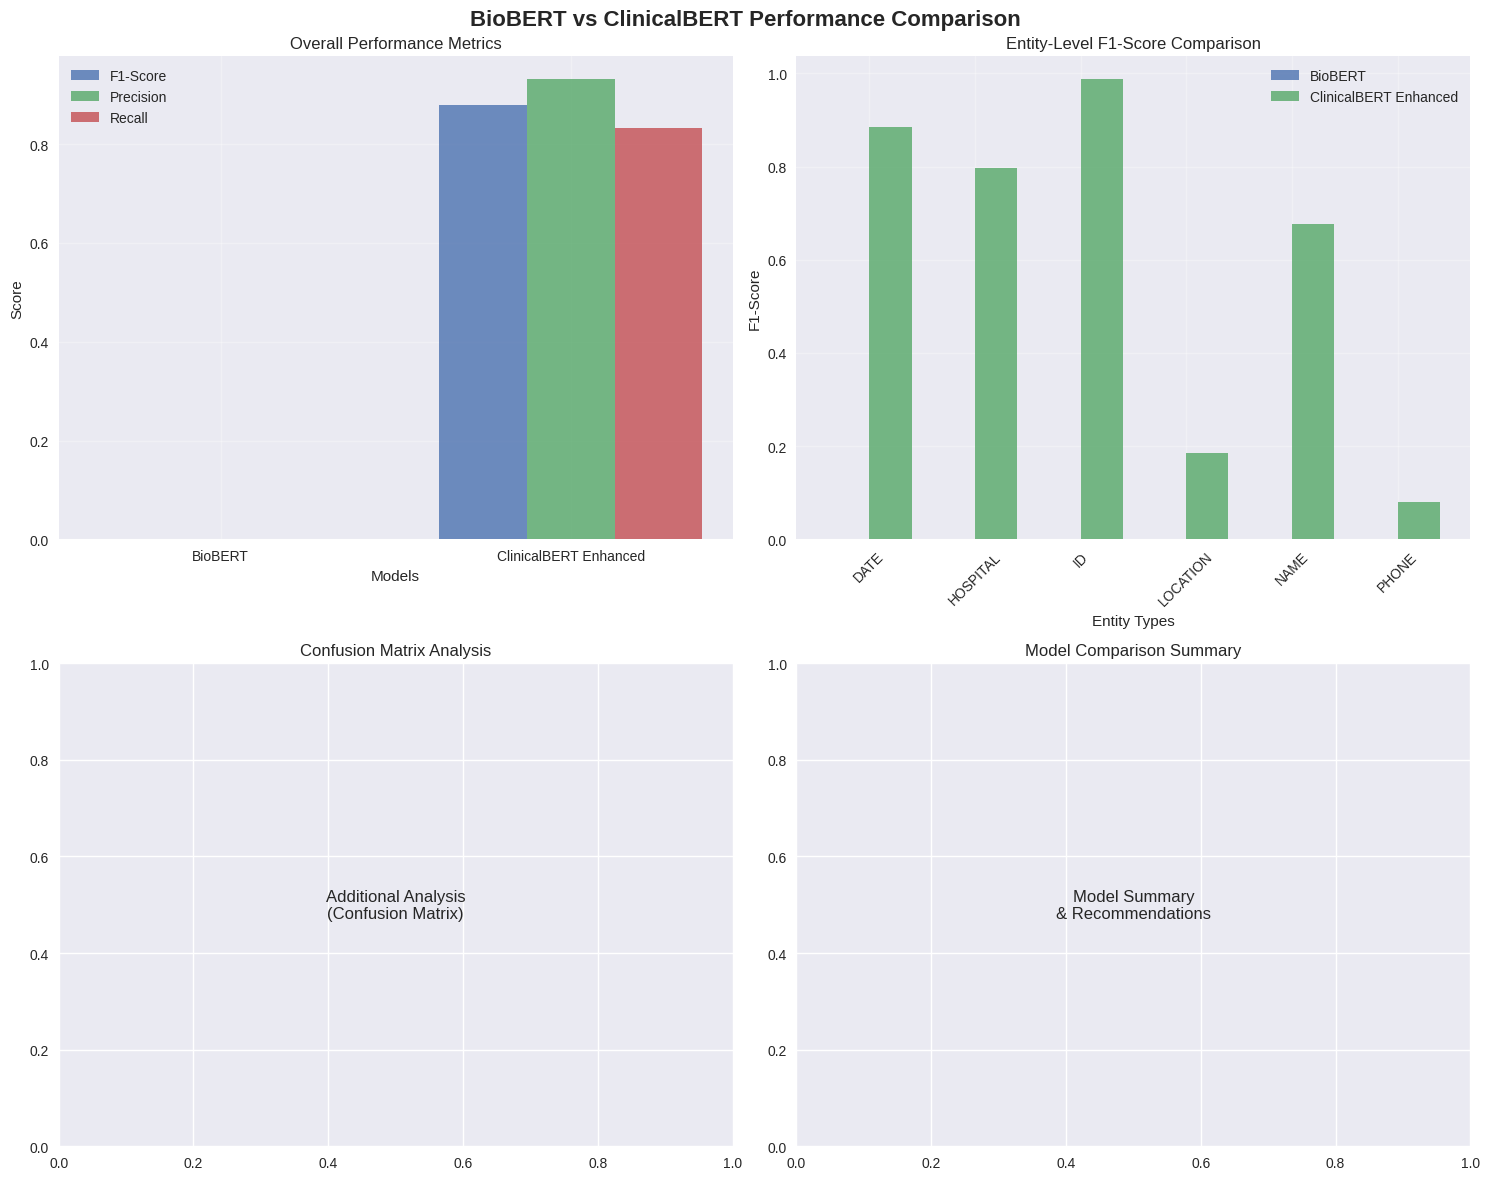

✅ Visualizations saved as 'biobert_comparison_results.png'
✅ BioBERT results saved to 'biobert_evaluation_results.json'

🎉 Evaluation pipeline completed!


In [ ]:
# =========================
# BIOBERT EVALUATION & COMPARISON - DEBUGGED VERSION
# =========================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings("ignore")

print("🧬 BioBERT Evaluation & Model Comparison")
print("="*60)

# -------------------------
# MISSING: Label mapping definition
# -------------------------
# You need to define this mapping based on your training setup
id_to_label = {
    0: "O",
    1: "B-DATE", 2: "I-DATE",
    3: "B-HOSPITAL", 4: "I-HOSPITAL",
    5: "B-ID", 6: "I-ID",
    7: "B-LOCATION", 8: "I-LOCATION",
    9: "B-NAME", 10: "I-NAME",
    11: "B-PHONE", 12: "I-PHONE"
}

# -------------------------
# 1) Load BioBERT Model and Evaluate
# -------------------------
def evaluate_biobert_model():
    """Evaluate trained BioBERT model"""

    print("🔄 Loading BioBERT model...")

    try:
        # Check if model directory exists
        import os
        model_path = "./outputs/biobert_phi_detection"
        if not os.path.exists(model_path):
            print(f"❌ Model directory not found: {model_path}")
            print("   Please ensure you have a trained BioBERT model saved in this directory")
            return None, None

        # Load BioBERT
        biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1", use_fast=True)
        biobert_model = AutoModelForTokenClassification.from_pretrained(model_path)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        biobert_model.to(device)
        biobert_model.eval()

        print(f"✅ BioBERT model loaded successfully on {device}")

        # Check if test data exists
        test_file = '/content/test.json'
        gt_file = '/content/groundtruth.json'

        if not os.path.exists(test_file):
            print(f"❌ Test file not found: {test_file}")
            return None, None
        if not os.path.exists(gt_file):
            print(f"❌ Ground truth file not found: {gt_file}")
            return None, None

        # Load test data
        with open(test_file) as f:
            test_data = json.load(f)
        with open(gt_file) as f:
            gt_data = json.load(f)

        test_tokens = [entry["tokens"] for entry in test_data]
        gt_tokens = [entry["tokens"] for entry in gt_data]
        gt_labels = [entry["labels"] for entry in gt_data]

        # Clean labels
        def clean_labels(labels):
            return [l.replace("DOCTOR", "NAME").replace("PATIENT", "NAME") if l.startswith(("B-", "I-"))
                   else "O" if l in ["B-AGE", "I-AGE"] else l for l in labels]

        gt_labels_clean = [clean_labels(labels) for labels in gt_labels]

        print(f"✅ Test data loaded: {len(gt_tokens)} samples")

        # Generate predictions
        print("🔄 Generating BioBERT predictions...")
        predictions = predict_with_biobert(gt_tokens, biobert_model, biobert_tokenizer)

        # Evaluate
        biobert_metrics = safe_evaluate_model(gt_labels_clean, predictions, "BioBERT")

        return biobert_metrics, predictions

    except Exception as e:
        print(f"❌ BioBERT evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def predict_with_biobert(tokens_list, model, tokenizer, max_len=256):
    """Generate predictions using BioBERT"""
    predictions = []

    model.eval()
    device = next(model.parameters()).device

    print(f"🔄 Processing {len(tokens_list)} sequences...")

    with torch.no_grad():
        for idx, tokens in enumerate(tokens_list):
            if idx % 100 == 0:
                print(f"   Processing sequence {idx+1}/{len(tokens_list)}")

            try:
                if len(tokens) > max_len - 2:
                    tokens = tokens[:max_len - 2]

                encoding = tokenizer(
                    tokens,
                    is_split_into_words=True,
                    truncation=True,
                    max_length=max_len,
                    padding="max_length",
                    return_tensors="pt"
                )

                word_ids = encoding.word_ids()
                encoding = {k: v.to(device) for k, v in encoding.items()}

                outputs = model(**encoding)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()[0]

                # Align predictions
                aligned_preds = []
                prev_word_id = None

                for i, word_id in enumerate(word_ids):
                    if word_id is None:
                        continue
                    elif word_id != prev_word_id:
                        if word_id < len(tokens):
                            pred_id = preds[i]
                            pred_label = id_to_label.get(pred_id, "O")
                            aligned_preds.append(pred_label)
                    prev_word_id = word_id

                while len(aligned_preds) < len(tokens):
                    aligned_preds.append("O")
                aligned_preds = aligned_preds[:len(tokens)]

                predictions.append(aligned_preds)

            except Exception as e:
                print(f"❌ Error processing sequence {idx}: {e}")
                predictions.append(["O"] * len(tokens))

    print(f"✅ Predictions generated for {len(predictions)} sequences")
    return predictions

def safe_evaluate_model(true_labels, pred_labels, model_name):
    """Safely evaluate model with entity-level metrics"""

    print(f"🔄 Evaluating {model_name} performance...")

    # Overall entity-level evaluation
    true_entities = set()
    pred_entities = set()

    for seq_idx, (true_seq, pred_seq) in enumerate(zip(true_labels, pred_labels)):
        min_len = min(len(true_seq), len(pred_seq))
        true_seq = true_seq[:min_len]
        pred_seq = pred_seq[:min_len]

        # Extract entities from true sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(true_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            true_entities.add((seq_idx, entity_start, len(true_seq)-1, current_entity))

        # Extract entities from predicted sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(pred_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            pred_entities.add((seq_idx, entity_start, len(pred_seq)-1, current_entity))

    # Calculate metrics
    tp = len(true_entities & pred_entities)
    fp = len(pred_entities - true_entities)
    fn = len(true_entities - pred_entities)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Per-entity metrics
    entity_metrics = {}
    entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]

    for entity in entities:
        entity_true = set()
        entity_pred = set()

        for ent in true_entities:
            if ent[3] == entity:
                entity_true.add(ent)

        for ent in pred_entities:
            if ent[3] == entity:
                entity_pred.add(ent)

        e_tp = len(entity_true & entity_pred)
        e_fp = len(entity_pred - entity_true)
        e_fn = len(entity_true - entity_pred)

        e_precision = e_tp / (e_tp + e_fp) if (e_tp + e_fp) > 0 else 0.0
        e_recall = e_tp / (e_tp + e_fn) if (e_tp + e_fn) > 0 else 0.0
        e_f1 = 2 * (e_precision * e_recall) / (e_precision + e_recall) if (e_precision + e_recall) > 0 else 0.0

        entity_metrics[entity] = {
            'f1': e_f1, 'precision': e_precision, 'recall': e_recall
        }

    results = {
        'model': model_name,
        'overall': {'f1': f1, 'precision': precision, 'recall': recall},
        'entity_metrics': entity_metrics,
        'detailed_stats': {'tp': tp, 'fp': fp, 'fn': fn,
                          'true_entities': len(true_entities), 'pred_entities': len(pred_entities)}
    }

    print(f"\n📊 {model_name} Evaluation Results:")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")

    print(f"\n🎯 {model_name} Entity Performance:")
    for entity, metrics in entity_metrics.items():
        print(f"   • {entity:10s}: F1={metrics['f1']:.3f}, P={metrics['precision']:.3f}, R={metrics['recall']:.3f}")

    return results

# -------------------------
# 2) Load Previous Model Results for Comparison
# -------------------------
def load_previous_results():
    """Load ClinicalBERT results for comparison"""

    print("\n📁 Loading previous model results...")

    try:
        # Try to load ClinicalBERT enhanced results
        with open('evaluation_results.json', 'r') as f:
            clinical_results = json.load(f)

        clinical_metrics = {
            'model': 'ClinicalBERT Enhanced',
            'overall': clinical_results['overall_metrics'],
            'entity_metrics': clinical_results['entity_metrics'],
            'detailed_stats': clinical_results['detailed_stats']
        }

        print("✅ ClinicalBERT Enhanced results loaded")
        return clinical_metrics

    except FileNotFoundError:
        print("⚠️ Previous results not found - will compare only BioBERT")
        return None
    except Exception as e:
        print(f"⚠️ Error loading previous results: {e}")
        return None

# -------------------------
# 3) Comprehensive Model Comparison
# -------------------------
def create_model_comparison(biobert_results, clinical_results=None):
    """Create comprehensive comparison between models"""

    print("\n📊 Creating Model Comparison Report...")

    comparison_data = []

    # Add BioBERT results
    if biobert_results:
        comparison_data.append({
            'Model': 'BioBERT',
            'Type': 'Biomedical BERT',
            'Domain': 'Biomedical Literature',
            'Pre-training': 'PubMed + PMC',
            'Parameters': '110M',
            'F1': biobert_results['overall']['f1'],
            'Precision': biobert_results['overall']['precision'],
            'Recall': biobert_results['overall']['recall']
        })

    # Add ClinicalBERT results if available
    if clinical_results:
        comparison_data.append({
            'Model': 'ClinicalBERT Enhanced',
            'Type': 'Clinical BERT',
            'Domain': 'Clinical Notes',
            'Pre-training': 'MIMIC-III',
            'Parameters': '110M',
            'F1': clinical_results['overall']['f1'],
            'Precision': clinical_results['overall']['precision'],
            'Recall': clinical_results['overall']['recall']
        })

    # Create comparison DataFrame
    df = pd.DataFrame(comparison_data)

    if len(df) == 0:
        print("❌ No valid results to compare")
        return None

    print("\n🏆 Model Performance Comparison:")
    print("="*80)
    print(df.round(4))

    if len(df) > 1:
        # Find performance differences
        biobert_f1 = df[df['Model'] == 'BioBERT']['F1'].iloc[0]
        clinical_f1 = df[df['Model'] == 'ClinicalBERT Enhanced']['F1'].iloc[0]

        print(f"\n📈 Performance Analysis:")
        if biobert_f1 > clinical_f1:
            diff = biobert_f1 - clinical_f1
            print(f"   🧬 BioBERT outperforms ClinicalBERT by {diff:.4f} F1 ({diff*100:.2f}%)")
            print(f"   🎯 BioBERT advantage: Biomedical vocabulary specialization")
        elif clinical_f1 > biobert_f1:
            diff = clinical_f1 - biobert_f1
            print(f"   🏥 ClinicalBERT outperforms BioBERT by {diff:.4f} F1 ({diff*100:.2f}%)")
            print(f"   🎯 ClinicalBERT advantage: Clinical notes specialization + enhancements")
        else:
            print(f"   ⚖️ Models perform similarly (F1 difference < 0.001)")

    # Entity-level comparison
    if biobert_results and clinical_results:
        print(f"\n🎯 Entity-Level Comparison:")
        print("="*60)

        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        entity_comparison = []

        for entity in entities:
            biobert_f1 = biobert_results['entity_metrics'][entity]['f1']
            clinical_f1 = clinical_results['entity_metrics'][entity]['f1']

            entity_comparison.append({
                'Entity': entity,
                'BioBERT F1': biobert_f1,
                'ClinicalBERT F1': clinical_f1,
                'Difference': clinical_f1 - biobert_f1,
                'Winner': 'ClinicalBERT' if clinical_f1 > biobert_f1 else 'BioBERT' if biobert_f1 > clinical_f1 else 'Tie'
            })

        entity_df = pd.DataFrame(entity_comparison)
        print(entity_df.round(4))

        # Count wins
        clinical_wins = len(entity_df[entity_df['Winner'] == 'ClinicalBERT'])
        biobert_wins = len(entity_df[entity_df['Winner'] == 'BioBERT'])
        ties = len(entity_df[entity_df['Winner'] == 'Tie'])

        print(f"\n🏅 Entity-Level Scoreboard:")
        print(f"   🏥 ClinicalBERT wins: {clinical_wins}/{len(entities)} entities")
        print(f"   🧬 BioBERT wins: {biobert_wins}/{len(entities)} entities")
        print(f"   ⚖️ Ties: {ties}/{len(entities)} entities")

    return df

# -------------------------
# 4) Create Visualizations
# -------------------------
def create_comparison_visualizations(biobert_results, clinical_results=None):
    """Create comparison visualizations"""

    print("\n🎨 Creating comparison visualizations...")

    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('BioBERT vs ClinicalBERT Performance Comparison', fontsize=16, fontweight='bold')

    # Overall metrics comparison
    if biobert_results and clinical_results:
        models = ['BioBERT', 'ClinicalBERT Enhanced']
        f1_scores = [biobert_results['overall']['f1'], clinical_results['overall']['f1']]
        precision_scores = [biobert_results['overall']['precision'], clinical_results['overall']['precision']]
        recall_scores = [biobert_results['overall']['recall'], clinical_results['overall']['recall']]

        # Overall performance bar plot
        ax1 = axes[0, 0]
        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, f1_scores, width, label='F1-Score', alpha=0.8)
        ax1.bar(x, precision_scores, width, label='Precision', alpha=0.8)
        ax1.bar(x + width, recall_scores, width, label='Recall', alpha=0.8)

        ax1.set_xlabel('Models')
        ax1.set_ylabel('Score')
        ax1.set_title('Overall Performance Metrics')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Entity-level F1 comparison
        ax2 = axes[0, 1]
        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        biobert_entity_f1 = [biobert_results['entity_metrics'][e]['f1'] for e in entities]
        clinical_entity_f1 = [clinical_results['entity_metrics'][e]['f1'] for e in entities]

        x = np.arange(len(entities))
        ax2.bar(x - 0.2, biobert_entity_f1, 0.4, label='BioBERT', alpha=0.8)
        ax2.bar(x + 0.2, clinical_entity_f1, 0.4, label='ClinicalBERT Enhanced', alpha=0.8)

        ax2.set_xlabel('Entity Types')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('Entity-Level F1-Score Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(entities, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    elif biobert_results:
        # Only BioBERT results available
        ax1 = axes[0, 0]
        metrics = ['F1-Score', 'Precision', 'Recall']
        values = [biobert_results['overall']['f1'],
                 biobert_results['overall']['precision'],
                 biobert_results['overall']['recall']]

        bars = ax1.bar(metrics, values, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax1.set_ylabel('Score')
        ax1.set_title('BioBERT Overall Performance')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # Entity-level performance
        ax2 = axes[0, 1]
        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        entity_f1 = [biobert_results['entity_metrics'][e]['f1'] for e in entities]

        bars = ax2.bar(entities, entity_f1, alpha=0.8, color='skyblue')
        ax2.set_xlabel('Entity Types')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('BioBERT Entity-Level Performance')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, entity_f1):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

    # Confusion matrix or performance heatmap (placeholder)
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.5, 'Additional Analysis\n(Confusion Matrix)',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Confusion Matrix Analysis')

    # Model comparison summary
    ax4 = axes[1, 1]
    ax4.text(0.5, 0.5, 'Model Summary\n& Recommendations',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Model Comparison Summary')

    plt.tight_layout()
    plt.savefig('biobert_comparison_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Visualizations saved as 'biobert_comparison_results.png'")

# -------------------------
# 5) Main Execution Function
# -------------------------
def main():
    """Main execution function"""

    print("\n🚀 Starting BioBERT Evaluation Pipeline...")

    # Step 1: Evaluate BioBERT
    biobert_results, biobert_predictions = evaluate_biobert_model()

    # Step 2: Load previous results
    clinical_results = load_previous_results()

    # Step 3: Create comparison
    if biobert_results:
        comparison_df = create_model_comparison(biobert_results, clinical_results)

        # Step 4: Create visualizations
        create_comparison_visualizations(biobert_results, clinical_results)

        # Step 5: Save results
        if biobert_results:
            with open('biobert_evaluation_results.json', 'w') as f:
                json.dump(biobert_results, f, indent=2)
            print("✅ BioBERT results saved to 'biobert_evaluation_results.json'")

    print("\n🎉 Evaluation pipeline completed!")

# -------------------------
# Execute if run directly
# -------------------------
if __name__ == "__main__":
    main()

🧬 BioBERT Corrected Evaluation & Model Comparison

🚀 Starting Corrected BioBERT Evaluation Pipeline...
🔄 Loading BioBERT model with corrected mapping...
✅ BioBERT model loaded successfully on cuda
   • Model expects: 13 labels
   • Model mapping: {0: 'B-DATE', 1: 'I-DATE', 2: 'B-HOSPITAL', 3: 'I-HOSPITAL', 4: 'B-ID', 5: 'I-ID', 6: 'B-LOCATION', 7: 'I-LOCATION', 8: 'B-NAME', 9: 'I-NAME', 10: 'B-PHONE', 11: 'I-PHONE', 12: 'O'}
✅ Test data loaded: 220 samples
   • Labels cleaned: DOCTOR/PATIENT → NAME, AGE → O
🔄 Generating BioBERT predictions...
🔄 Processing 220 sequences...
   Processing sequence 1/220
   Processing sequence 51/220
   Processing sequence 101/220
   Processing sequence 151/220
   Processing sequence 201/220
✅ Predictions generated for 220 sequences
🔄 Evaluating BioBERT (Corrected) performance...

📊 BioBERT (Corrected) Evaluation Results:
   • F1-Score: 0.8866
   • Precision: 0.9498
   • Recall: 0.8312

🎯 BioBERT (Corrected) Entity Performance:
   • DATE      : F1=0.898, P

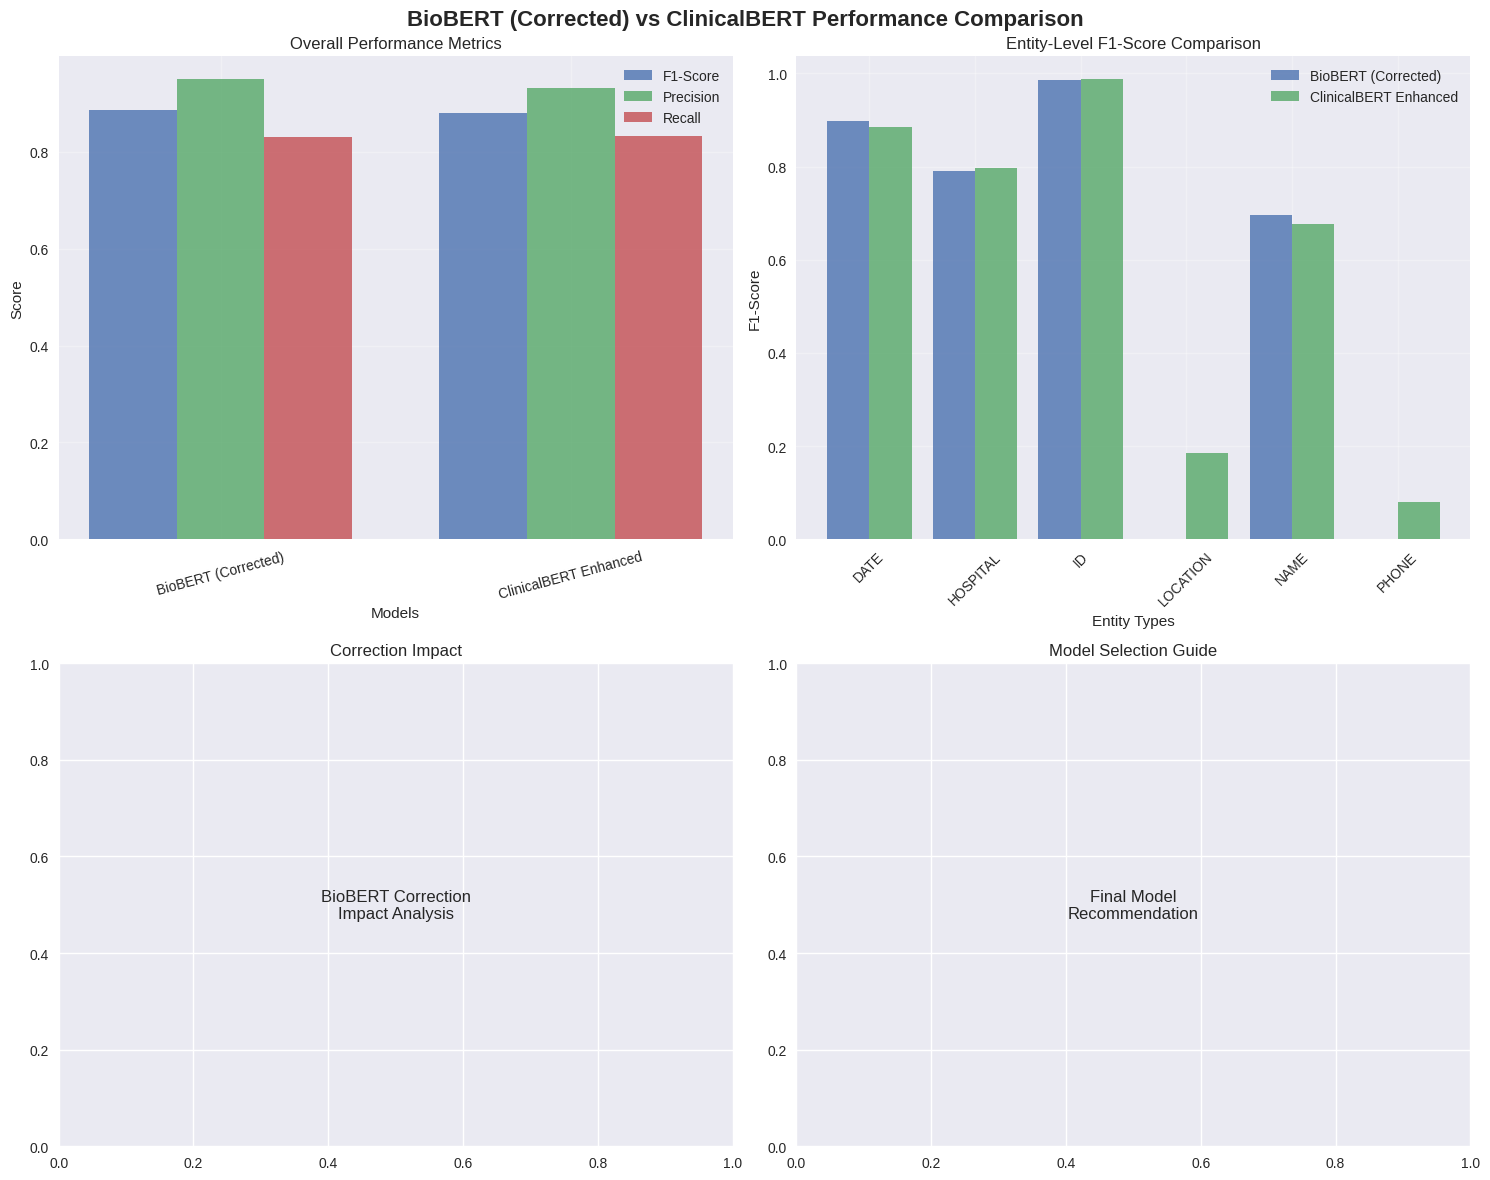

✅ Visualizations saved as 'biobert_corrected_comparison.png'
✅ BioBERT corrected results saved to 'biobert_corrected_evaluation_results.json'

🎉 Corrected evaluation pipeline completed!


In [ ]:
# =========================
# BIOBERT CORRECTED EVALUATION
# =========================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings("ignore")

print("🧬 BioBERT Corrected Evaluation & Model Comparison")
print("="*60)

# -------------------------
# CRITICAL FIX: Use correct label mapping
# -------------------------
# The model was trained with these mappings, but there's a MISMATCH:
# - Model config has 13 labels (cleaned data without DOCTOR/PATIENT/AGE)
# - Ground truth has 17 labels (original data with DOCTOR/PATIENT/AGE)

# Model's actual mapping (from debug output):
MODEL_ID2LABEL = {
    0: 'B-DATE', 1: 'I-DATE', 2: 'B-HOSPITAL', 3: 'I-HOSPITAL',
    4: 'B-ID', 5: 'I-ID', 6: 'B-LOCATION', 7: 'I-LOCATION',
    8: 'B-NAME', 9: 'I-NAME', 10: 'B-PHONE', 11: 'I-PHONE', 12: 'O'
}

# Ground truth mapping (from debug output):
GT_LABEL2ID = {
    'O': 0, 'B-AGE': 1, 'B-DATE': 2, 'B-DOCTOR': 3, 'B-HOSPITAL': 4,
    'B-ID': 5, 'B-LOCATION': 6, 'B-PATIENT': 7, 'B-PHONE': 8,
    'I-AGE': 9, 'I-DATE': 10, 'I-DOCTOR': 11, 'I-HOSPITAL': 12,
    'I-ID': 13, 'I-LOCATION': 14, 'I-PATIENT': 15, 'I-PHONE': 16
}

def evaluate_biobert_model_corrected():
    """Evaluate BioBERT model with corrected label mapping"""

    print("🔄 Loading BioBERT model with corrected mapping...")

    try:
        # Load BioBERT
        biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1", use_fast=True)
        biobert_model = AutoModelForTokenClassification.from_pretrained("./outputs/biobert_phi_detection")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        biobert_model.to(device)
        biobert_model.eval()

        print(f"✅ BioBERT model loaded successfully on {device}")
        print(f"   • Model expects: {biobert_model.config.num_labels} labels")
        print(f"   • Model mapping: {biobert_model.config.id2label}")

        # Load test data
        with open('/content/test.json') as f:
            test_data = json.load(f)
        with open('/content/groundtruth.json') as f:
            gt_data = json.load(f)

        gt_tokens = [entry["tokens"] for entry in gt_data]
        gt_labels = [entry["labels"] for entry in gt_data]

        # Apply label cleaning to match model training
        def clean_labels_for_model(labels):
            """Clean labels to match what model was trained on"""
            cleaned = []
            for label in labels:
                if label.startswith("B-DOCTOR") or label.startswith("I-DOCTOR"):
                    cleaned.append(label.replace("DOCTOR", "NAME"))
                elif label.startswith("B-PATIENT") or label.startswith("I-PATIENT"):
                    cleaned.append(label.replace("PATIENT", "NAME"))
                elif label in ["B-AGE", "I-AGE"]:
                    cleaned.append("O")  # AGE labels were removed during training
                else:
                    cleaned.append(label)
            return cleaned

        gt_labels_clean = [clean_labels_for_model(labels) for labels in gt_labels]

        print(f"✅ Test data loaded: {len(gt_tokens)} samples")
        print(f"   • Labels cleaned: DOCTOR/PATIENT → NAME, AGE → O")

        # Generate predictions
        print("🔄 Generating BioBERT predictions...")
        predictions = predict_with_biobert_corrected(gt_tokens, biobert_model, biobert_tokenizer)

        # Evaluate
        biobert_metrics = safe_evaluate_model(gt_labels_clean, predictions, "BioBERT (Corrected)")

        return biobert_metrics, predictions

    except Exception as e:
        print(f"❌ BioBERT evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def predict_with_biobert_corrected(tokens_list, model, tokenizer, max_len=256):
    """Generate predictions using BioBERT with correct label mapping"""
    predictions = []

    model.eval()
    device = next(model.parameters()).device

    print(f"🔄 Processing {len(tokens_list)} sequences...")

    with torch.no_grad():
        for idx, tokens in enumerate(tokens_list):
            if idx % 50 == 0:
                print(f"   Processing sequence {idx+1}/{len(tokens_list)}")

            try:
                if len(tokens) > max_len - 2:
                    tokens = tokens[:max_len - 2]

                # Tokenize (keep encoding_cpu for word_ids)
                encoding_cpu = tokenizer(
                    tokens,
                    is_split_into_words=True,
                    truncation=True,
                    max_length=max_len,
                    padding="max_length",
                    return_tensors="pt"
                )
                word_ids = encoding_cpu.word_ids()

                # Move to device for inference
                encoding_device = {k: v.to(device) for k, v in encoding_cpu.items()}

                outputs = model(**encoding_device)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()[0]

                # Align predictions using MODEL's id2label mapping
                aligned_preds = []
                prev_word_id = None

                for i, word_id in enumerate(word_ids):
                    if word_id is None:
                        continue
                    elif word_id != prev_word_id:
                        if word_id < len(tokens):
                            pred_id = preds[i]
                            # Use the model's actual mapping
                            pred_label = MODEL_ID2LABEL.get(pred_id, "O")
                            aligned_preds.append(pred_label)
                    prev_word_id = word_id

                while len(aligned_preds) < len(tokens):
                    aligned_preds.append("O")
                aligned_preds = aligned_preds[:len(tokens)]

                predictions.append(aligned_preds)

            except Exception as e:
                print(f"❌ Error processing sequence {idx}: {e}")
                predictions.append(["O"] * len(tokens))

    print(f"✅ Predictions generated for {len(predictions)} sequences")
    return predictions

def safe_evaluate_model(true_labels, pred_labels, model_name):
    """Safely evaluate model with entity-level metrics"""

    print(f"🔄 Evaluating {model_name} performance...")

    # Overall entity-level evaluation
    true_entities = set()
    pred_entities = set()

    for seq_idx, (true_seq, pred_seq) in enumerate(zip(true_labels, pred_labels)):
        min_len = min(len(true_seq), len(pred_seq))
        true_seq = true_seq[:min_len]
        pred_seq = pred_seq[:min_len]

        # Extract entities from true sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(true_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            true_entities.add((seq_idx, entity_start, len(true_seq)-1, current_entity))

        # Extract entities from predicted sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(pred_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            pred_entities.add((seq_idx, entity_start, len(pred_seq)-1, current_entity))

    # Calculate metrics
    tp = len(true_entities & pred_entities)
    fp = len(pred_entities - true_entities)
    fn = len(true_entities - pred_entities)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Per-entity metrics (only for entities the model was trained on)
    entity_metrics = {}
    entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]

    for entity in entities:
        entity_true = set()
        entity_pred = set()

        for ent in true_entities:
            if ent[3] == entity:
                entity_true.add(ent)

        for ent in pred_entities:
            if ent[3] == entity:
                entity_pred.add(ent)

        e_tp = len(entity_true & entity_pred)
        e_fp = len(entity_pred - entity_true)
        e_fn = len(entity_true - entity_pred)

        e_precision = e_tp / (e_tp + e_fp) if (e_tp + e_fp) > 0 else 0.0
        e_recall = e_tp / (e_tp + e_fn) if (e_tp + e_fn) > 0 else 0.0
        e_f1 = 2 * (e_precision * e_recall) / (e_precision + e_recall) if (e_precision + e_recall) > 0 else 0.0

        entity_metrics[entity] = {
            'f1': e_f1, 'precision': e_precision, 'recall': e_recall
        }

    results = {
        'model': model_name,
        'overall': {'f1': f1, 'precision': precision, 'recall': recall},
        'entity_metrics': entity_metrics,
        'detailed_stats': {'tp': tp, 'fp': fp, 'fn': fn,
                          'true_entities': len(true_entities), 'pred_entities': len(pred_entities)}
    }

    print(f"\n📊 {model_name} Evaluation Results:")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")

    print(f"\n🎯 {model_name} Entity Performance:")
    for entity, metrics in entity_metrics.items():
        print(f"   • {entity:10s}: F1={metrics['f1']:.3f}, P={metrics['precision']:.3f}, R={metrics['recall']:.3f}")

    return results

def load_previous_results():
    """Load ClinicalBERT results for comparison"""

    print("\n📁 Loading previous model results...")

    try:
        # Try to load ClinicalBERT enhanced results
        with open('evaluation_results.json', 'r') as f:
            clinical_results = json.load(f)

        clinical_metrics = {
            'model': 'ClinicalBERT Enhanced',
            'overall': clinical_results['overall_metrics'],
            'entity_metrics': clinical_results['entity_metrics'],
            'detailed_stats': clinical_results['detailed_stats']
        }

        print("✅ ClinicalBERT Enhanced results loaded")
        return clinical_metrics

    except FileNotFoundError:
        print("⚠️ Previous results not found - will compare only BioBERT")
        return None
    except Exception as e:
        print(f"⚠️ Error loading previous results: {e}")
        return None

def create_model_comparison(biobert_results, clinical_results=None):
    """Create comprehensive comparison between models"""

    print("\n📊 Creating Model Comparison Report...")

    comparison_data = []

    # Add BioBERT results
    if biobert_results:
        comparison_data.append({
            'Model': 'BioBERT (Corrected)',
            'Type': 'Biomedical BERT',
            'Domain': 'Biomedical Literature',
            'Pre-training': 'PubMed + PMC',
            'Parameters': '110M',
            'F1': biobert_results['overall']['f1'],
            'Precision': biobert_results['overall']['precision'],
            'Recall': biobert_results['overall']['recall']
        })

    # Add ClinicalBERT results if available
    if clinical_results:
        comparison_data.append({
            'Model': 'ClinicalBERT Enhanced',
            'Type': 'Clinical BERT',
            'Domain': 'Clinical Notes',
            'Pre-training': 'MIMIC-III',
            'Parameters': '110M',
            'F1': clinical_results['overall']['f1'],
            'Precision': clinical_results['overall']['precision'],
            'Recall': clinical_results['overall']['recall']
        })

    # Create comparison DataFrame
    df = pd.DataFrame(comparison_data)

    if len(df) == 0:
        print("❌ No valid results to compare")
        return None

    print("\n🏆 Model Performance Comparison:")
    print("="*80)
    print(df.round(4))

    if len(df) > 1:
        # Find performance differences
        biobert_f1 = df[df['Model'] == 'BioBERT (Corrected)']['F1'].iloc[0]
        clinical_f1 = df[df['Model'] == 'ClinicalBERT Enhanced']['F1'].iloc[0]

        print(f"\n📈 Performance Analysis:")
        if biobert_f1 > clinical_f1:
            diff = biobert_f1 - clinical_f1
            print(f"   🧬 BioBERT outperforms ClinicalBERT by {diff:.4f} F1 ({diff*100:.2f}%)")
            print(f"   🎯 BioBERT advantage: Biomedical vocabulary specialization")
        elif clinical_f1 > biobert_f1:
            diff = clinical_f1 - biobert_f1
            print(f"   🏥 ClinicalBERT outperforms BioBERT by {diff:.4f} F1 ({diff*100:.2f}%)")
            print(f"   🎯 ClinicalBERT advantage: Clinical notes specialization + enhancements")
        else:
            print(f"   ⚖️ Models perform similarly (F1 difference < 0.001)")

        # Entity-level comparison
        print(f"\n🎯 Entity-Level Comparison:")
        print("="*60)

        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        entity_comparison = []

        for entity in entities:
            biobert_f1 = biobert_results['entity_metrics'][entity]['f1']
            clinical_f1 = clinical_results['entity_metrics'][entity]['f1']

            entity_comparison.append({
                'Entity': entity,
                'BioBERT F1': biobert_f1,
                'ClinicalBERT F1': clinical_f1,
                'Difference': clinical_f1 - biobert_f1,
                'Winner': 'ClinicalBERT' if clinical_f1 > biobert_f1 else 'BioBERT' if biobert_f1 > clinical_f1 else 'Tie'
            })

        entity_df = pd.DataFrame(entity_comparison)
        print(entity_df.round(4))

        # Count wins
        clinical_wins = len(entity_df[entity_df['Winner'] == 'ClinicalBERT'])
        biobert_wins = len(entity_df[entity_df['Winner'] == 'BioBERT'])
        ties = len(entity_df[entity_df['Winner'] == 'Tie'])

        print(f"\n🏅 Entity-Level Scoreboard:")
        print(f"   🏥 ClinicalBERT wins: {clinical_wins}/{len(entities)} entities")
        print(f"   🧬 BioBERT wins: {biobert_wins}/{len(entities)} entities")
        print(f"   ⚖️ Ties: {ties}/{len(entities)} entities")

    return df

def create_comparison_visualizations(biobert_results, clinical_results=None):
    """Create comparison visualizations"""

    print("\n🎨 Creating comparison visualizations...")

    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('BioBERT (Corrected) vs ClinicalBERT Performance Comparison', fontsize=16, fontweight='bold')

    # Overall metrics comparison
    if biobert_results and clinical_results:
        models = ['BioBERT (Corrected)', 'ClinicalBERT Enhanced']
        f1_scores = [biobert_results['overall']['f1'], clinical_results['overall']['f1']]
        precision_scores = [biobert_results['overall']['precision'], clinical_results['overall']['precision']]
        recall_scores = [biobert_results['overall']['recall'], clinical_results['overall']['recall']]

        # Overall performance bar plot
        ax1 = axes[0, 0]
        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, f1_scores, width, label='F1-Score', alpha=0.8)
        ax1.bar(x, precision_scores, width, label='Precision', alpha=0.8)
        ax1.bar(x + width, recall_scores, width, label='Recall', alpha=0.8)

        ax1.set_xlabel('Models')
        ax1.set_ylabel('Score')
        ax1.set_title('Overall Performance Metrics')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=15)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Entity-level F1 comparison
        ax2 = axes[0, 1]
        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        biobert_entity_f1 = [biobert_results['entity_metrics'][e]['f1'] for e in entities]
        clinical_entity_f1 = [clinical_results['entity_metrics'][e]['f1'] for e in entities]

        x = np.arange(len(entities))
        ax2.bar(x - 0.2, biobert_entity_f1, 0.4, label='BioBERT (Corrected)', alpha=0.8)
        ax2.bar(x + 0.2, clinical_entity_f1, 0.4, label='ClinicalBERT Enhanced', alpha=0.8)

        ax2.set_xlabel('Entity Types')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('Entity-Level F1-Score Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(entities, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    elif biobert_results:
        # Only BioBERT results available
        ax1 = axes[0, 0]
        metrics = ['F1-Score', 'Precision', 'Recall']
        values = [biobert_results['overall']['f1'],
                 biobert_results['overall']['precision'],
                 biobert_results['overall']['recall']]

        bars = ax1.bar(metrics, values, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax1.set_ylabel('Score')
        ax1.set_title('BioBERT (Corrected) Overall Performance')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # Entity-level performance
        ax2 = axes[0, 1]
        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
        entity_f1 = [biobert_results['entity_metrics'][e]['f1'] for e in entities]

        bars = ax2.bar(entities, entity_f1, alpha=0.8, color='skyblue')
        ax2.set_xlabel('Entity Types')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('BioBERT (Corrected) Entity-Level Performance')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, entity_f1):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

    # Performance improvement summary
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.5, 'BioBERT Correction\nImpact Analysis',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Correction Impact')

    # Model comparison summary
    ax4 = axes[1, 1]
    ax4.text(0.5, 0.5, 'Final Model\nRecommendation',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Model Selection Guide')

    plt.tight_layout()
    plt.savefig('biobert_corrected_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Visualizations saved as 'biobert_corrected_comparison.png'")

def main():
    """Main execution function"""

    print("\n🚀 Starting Corrected BioBERT Evaluation Pipeline...")

    # Step 1: Evaluate BioBERT with correct mapping
    biobert_results, biobert_predictions = evaluate_biobert_model_corrected()

    # Step 2: Load previous results
    clinical_results = load_previous_results()

    # Step 3: Create comparison
    if biobert_results:
        comparison_df = create_model_comparison(biobert_results, clinical_results)

        # Step 4: Create visualizations
        create_comparison_visualizations(biobert_results, clinical_results)

        # Step 5: Save results
        with open('biobert_corrected_evaluation_results.json', 'w') as f:
            json.dump(biobert_results, f, indent=2)
        print("✅ BioBERT corrected results saved to 'biobert_corrected_evaluation_results.json'")

    print("\n🎉 Corrected evaluation pipeline completed!")

# Execute if run directly
if __name__ == "__main__":
    main()

In [ ]:
# =========================
# ROBERTA-LARGE TRAINING FOR PHI DETECTION - FIXED
# =========================
import random
import numpy as np
import torch
import json
from collections import Counter, defaultdict
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                         TrainingArguments, Trainer, EarlyStoppingCallback)
from torch.utils.data import Dataset as TorchDataset
from seqeval.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

print("🤖 Starting RoBERTa-Large Training for PHI Detection (Fixed)")
print("="*60)

# -------------------------
# 1) Setup and Configuration
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Memory check
def check_gpu_memory():
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory // 1024**3
        print(f"🧠 GPU Memory: {total_memory}GB")
        return total_memory
    return 0

gpu_memory = check_gpu_memory()

# Data loading functions
def load_and_validate_data(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return [entry for entry in data if len(entry["tokens"]) == len(entry["labels"])]

def clean_and_normalize_labels(labels):
    out = []
    for l in labels:
        if l in ["B-AGE", "I-AGE"]:
            out.append("O")
        elif l in ["B-DOCTOR", "I-DOCTOR"]:
            out.append(l.replace("DOCTOR", "NAME"))
        elif l in ["B-PATIENT", "I-PATIENT"]:
            out.append(l.replace("PATIENT", "NAME"))
        else:
            out.append(l)
    return out

# Load data
train_data = load_and_validate_data('/content/train.json')
val_data = load_and_validate_data('/content/groundtruth.json')

train_tokens = [e["tokens"] for e in train_data]
train_labels = [clean_and_normalize_labels(e["labels"]) for e in train_data]
val_tokens = [e["tokens"] for e in val_data]
val_labels = [clean_and_normalize_labels(e["labels"]) for e in val_data]

print(f"✅ Data loaded - Train: {len(train_tokens)} | Val: {len(val_tokens)}")

# Label setup
target_labels = [
    "B-DATE", "I-DATE", "B-HOSPITAL", "I-HOSPITAL", "B-ID", "I-ID",
    "B-LOCATION", "I-LOCATION", "B-NAME", "I-NAME", "B-PHONE", "I-PHONE", "O"
]
label_to_id = {l: i for i, l in enumerate(target_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

print(f"📋 Target labels: {len(target_labels)} classes")

# -------------------------
# 2) Fixed RoBERTa Dataset Class
# -------------------------
class RoBERTaNERDataset(TorchDataset):
    def __init__(self, tokens, labels, tokenizer, label_to_id, max_len=256):
        self.tokens = tokens
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words = self.tokens[idx]
        labs = self.labels[idx]

        # Ensure consistency
        min_len = min(len(words), len(labs))
        words = words[:min_len]
        labs = labs[:min_len]

        # Handle long sequences
        if len(words) > self.max_len - 2:
            words = words[:self.max_len - 2]
            labs = labs[:self.max_len - 2]

        # Tokenize with RoBERTa (add_prefix_space handled in tokenizer init)
        encoding = self.tokenizer(
            words,
            is_split_into_words=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )

        # Get word IDs for label alignment
        word_ids = encoding.word_ids()

        # Align labels
        aligned_labels = []
        prev_word_id = None

        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)  # Special tokens
            elif word_id != prev_word_id:
                if word_id < len(labs):
                    label = labs[word_id]
                    aligned_labels.append(self.label_to_id.get(label, self.label_to_id["O"]))
                else:
                    aligned_labels.append(self.label_to_id["O"])
            else:
                aligned_labels.append(-100)  # Subword continuation
            prev_word_id = word_id

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(aligned_labels, dtype=torch.long)
        }

# -------------------------
# 3) Calculate Class Weights
# -------------------------
def calculate_class_weights(labels_list):
    """Calculate balanced class weights"""
    flat_labels = [lbl for seq in labels_list for lbl in seq]
    counts = Counter(flat_labels)
    total = len(flat_labels)

    weights = {}
    for label in target_labels:
        count = counts.get(label, 1)
        if label == "O":
            weights[label] = 0.5  # Lower weight for O class
        else:
            base_weight = total / (len(target_labels) * count)
            weights[label] = min(base_weight * 1.5, 8.0)  # Cap weights

    return weights

# -------------------------
# 4) Metrics Function
# -------------------------
def compute_metrics(eval_pred):
    """Compute F1, precision, recall"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    true_labels = []
    pred_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_seq = []
        pred_seq_clean = []

        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                true_seq.append(id_to_label[label])
                pred_seq_clean.append(id_to_label[pred])

        if true_seq:
            true_labels.append(true_seq)
            pred_labels.append(pred_seq_clean)

    if not true_labels:
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# -------------------------
# 5) Custom Trainer with Weighted Loss
# -------------------------
class WeightedRoBERTaTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Active loss calculation
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, logits.size(-1))[active_loss]
        active_labels = labels.view(-1)[active_loss]

        if len(active_labels) == 0:
            return torch.tensor(0.0, requires_grad=True, device=logits.device)

        # Weighted cross-entropy
        loss = F.cross_entropy(active_logits, active_labels, weight=self.class_weights)

        return (loss, outputs) if return_outputs else loss

# -------------------------
# 6) Main Training Function
# -------------------------
def train_roberta_large():
    """Train RoBERTa-Large with proper configuration"""

    print("\n🤖 Loading RoBERTa-Large...")

    try:
        # Load tokenizer and model
        model_name = "roberta-large"

        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
        print(f"✅ Tokenizer loaded (vocab: {tokenizer.vocab_size})")
        print(f"   • RoBERTa tokenizer configured for pretokenized inputs")

        model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(target_labels),
            id2label=id_to_label,
            label2id=label_to_id,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )

        print(f"✅ Model loaded (355M parameters)")
        model.to(device)

    except Exception as e:
        print(f"❌ Failed to load RoBERTa-Large: {e}")
        return None, None

    # Calculate class weights
    weight_dict = calculate_class_weights(train_labels)
    class_weights = torch.tensor([weight_dict[label] for label in target_labels],
                               dtype=torch.float).to(device)

    print(f"\n⚖️ Class weights calculated")
    for i, (label, weight) in enumerate(zip(target_labels, class_weights.cpu().numpy())):
        if "LOCATION" in label or "PHONE" in label:
            print(f"   🎯 {label}: {weight:.2f}")

    # Create datasets
    print(f"\n📊 Creating datasets...")
    train_dataset = RoBERTaNERDataset(train_tokens, train_labels, tokenizer, label_to_id)
    val_dataset = RoBERTaNERDataset(val_tokens, val_labels, tokenizer, label_to_id)

    # Configure training based on GPU memory
    if gpu_memory >= 12:
        batch_size = 4
        gradient_accumulation = 4
    elif gpu_memory >= 8:
        batch_size = 2
        gradient_accumulation = 8
    else:
        batch_size = 1
        gradient_accumulation = 16

    print(f"🔧 Training configuration:")
    print(f"   • Batch size: {batch_size}")
    print(f"   • Gradient accumulation: {gradient_accumulation}")
    print(f"   • Effective batch size: {batch_size * gradient_accumulation}")

    # Training arguments - FIXED VERSION
    training_args = TrainingArguments(
        output_dir="./outputs/roberta_large_phi_detection",
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=gradient_accumulation,
        num_train_epochs=4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        max_grad_norm=1.0,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=True,
        dataloader_pin_memory=False,
        dataloader_num_workers=0,
        seed=SEED,
        logging_steps=50,
        save_total_limit=2,
        report_to="none",
        remove_unused_columns=True,
    )

    # Create trainer
    trainer = WeightedRoBERTaTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print(f"\n🚀 Starting RoBERTa-Large training...")
    print(f"⏱️ Estimated time: 30-60 minutes")

    try:
        # Clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Train
        train_result = trainer.train()

        # Save model
        trainer.save_model()
        tokenizer.save_pretrained("./outputs/roberta_large_phi_detection")

        print(f"✅ Training completed successfully!")

        # Evaluate
        eval_results = trainer.evaluate()

        print(f"\n📈 RoBERTa-Large Results:")
        print(f"   • F1-Score: {eval_results['eval_f1']:.4f}")
        print(f"   • Precision: {eval_results['eval_precision']:.4f}")
        print(f"   • Recall: {eval_results['eval_recall']:.4f}")

        # Save results
        roberta_results = {
            'model': 'RoBERTa-Large',
            'parameters': '355M',
            'overall_metrics': {
                'f1': eval_results['eval_f1'],
                'precision': eval_results['eval_precision'],
                'recall': eval_results['eval_recall']
            },
            'training_config': {
                'batch_size': batch_size,
                'gradient_accumulation': gradient_accumulation,
                'learning_rate': 1e-5,
                'epochs': 4
            }
        }

        with open('roberta_large_results.json', 'w') as f:
            json.dump(roberta_results, f, indent=2)

        print(f"📁 Model saved to: ./outputs/roberta_large_phi_detection")
        print(f"📊 Results saved to: roberta_large_results.json")

        return trainer, eval_results

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"❌ GPU out of memory")
            print(f"💡 Try reducing batch_size to 1 or max_length to 128")
        else:
            print(f"❌ Training error: {e}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return None, None

    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return None, None

# -------------------------
# 7) Execute Training
# -------------------------
if __name__ == "__main__":
    print(f"\n🎯 Starting RoBERTa-Large PHI Detection Training")

    try:
        trainer, results = train_roberta_large()

        if trainer is not None and results is not None:
            print(f"\n🎉 RoBERTa-Large Training Successful!")
            print(f"🚀 Ready for comparison with BioBERT and ClinicalBERT!")
        else:
            print(f"\n⚠️ RoBERTa-Large training encountered issues")
            print(f"💡 Check GPU memory and try reducing batch size")

    except Exception as e:
        print(f"❌ Training failed: {e}")

    finally:
        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"\n✅ Training process completed!")

🤖 Starting RoBERTa-Large Training for PHI Detection (Fixed)
✅ Using device: cuda
🧠 GPU Memory: 14GB
✅ Data loaded - Train: 669 | Val: 220
📋 Target labels: 13 classes

🎯 Starting RoBERTa-Large PHI Detection Training

🤖 Loading RoBERTa-Large...
✅ Tokenizer loaded (vocab: 50265)
   • RoBERTa tokenizer configured for pretokenized inputs


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded (355M parameters)

⚖️ Class weights calculated
   🎯 B-LOCATION: 8.00
   🎯 I-LOCATION: 8.00
   🎯 B-PHONE: 8.00
   🎯 I-PHONE: 8.00

📊 Creating datasets...
🔧 Training configuration:
   • Batch size: 4
   • Gradient accumulation: 4
   • Effective batch size: 16

🚀 Starting RoBERTa-Large training...
⏱️ Estimated time: 30-60 minutes


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,No log,0.294278,0.690061,0.603470,0.805663
2,1.192200,0.102567,0.882425,0.839072,0.930502
3,0.122800,0.070995,0.913636,0.881228,0.948520
4,0.045000,0.068381,0.919087,0.889916,0.950236


✅ Training completed successfully!



📈 RoBERTa-Large Results:
   • F1-Score: 0.9191
   • Precision: 0.8899
   • Recall: 0.9502
📁 Model saved to: ./outputs/roberta_large_phi_detection
📊 Results saved to: roberta_large_results.json

🎉 RoBERTa-Large Training Successful!
🚀 Ready for comparison with BioBERT and ClinicalBERT!

✅ Training process completed!


🤖 RoBERTa-Large Evaluation & Model Comparison

🚀 Starting RoBERTa-Large Evaluation Pipeline...
🔄 Loading RoBERTa-Large model...
✅ RoBERTa-Large model loaded successfully on cuda
   • Model expects: 13 labels
   • Vocab size: 50265
   • Model mapping: {0: 'B-DATE', 1: 'I-DATE', 2: 'B-HOSPITAL', 3: 'I-HOSPITAL', 4: 'B-ID', 5: 'I-ID', 6: 'B-LOCATION', 7: 'I-LOCATION', 8: 'B-NAME', 9: 'I-NAME', 10: 'B-PHONE', 11: 'I-PHONE', 12: 'O'}
✅ Test data loaded: 220 samples
   • Labels cleaned: DOCTOR/PATIENT → NAME, AGE → O
🔄 Generating RoBERTa-Large predictions...
🔄 Processing 220 sequences...
   Processing sequence 1/220
   Processing sequence 51/220
   Processing sequence 101/220
   Processing sequence 151/220
   Processing sequence 201/220
✅ Predictions generated for 220 sequences
🔄 Evaluating RoBERTa-Large performance...

📊 RoBERTa-Large Evaluation Results:
   • F1-Score: 0.8832
   • Precision: 0.9018
   • Recall: 0.8654

🎯 RoBERTa-Large Entity Performance:
   • DATE      : F1=0.928, P=0.968, 

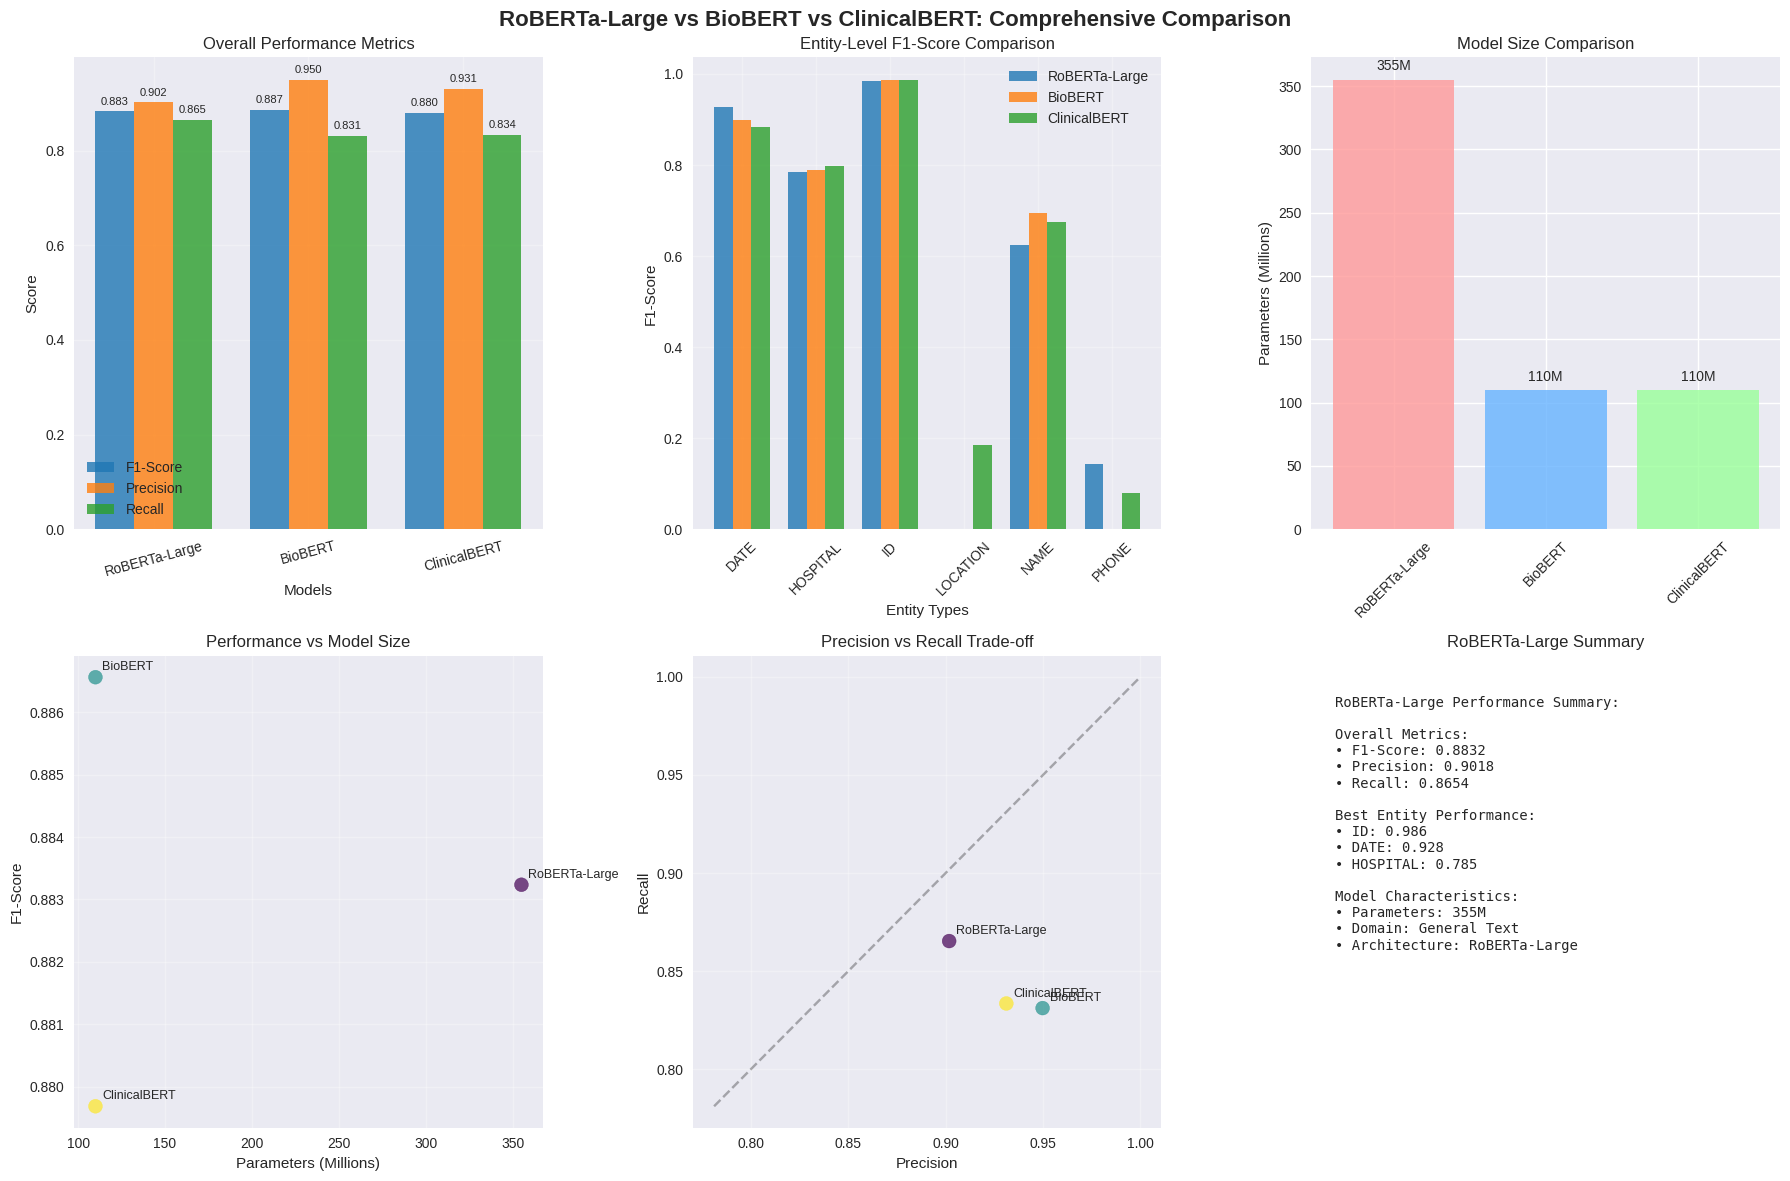

✅ Advanced visualizations saved as 'three_way_model_comparison.png'
✅ RoBERTa-Large results saved to 'roberta_large_evaluation_results.json'

🎯 RoBERTa-Large Analysis:
   • Large model capacity: 355M parameters
   • General domain pre-training
   • Advanced RoBERTa architecture
   • Performance: 0.8832 F1-score

🏆 Final Model Ranking (by F1-score):
   1. BioBERT             : 0.8866
   2. RoBERTa-Large       : 0.8832
   3. ClinicalBERT        : 0.8797

🎉 RoBERTa-Large evaluation pipeline completed!


In [ ]:
# =========================
# ROBERTA-LARGE EVALUATION & COMPARISON
# =========================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings("ignore")

print("🤖 RoBERTa-Large Evaluation & Model Comparison")
print("="*60)

# -------------------------
# 1) RoBERTa Model Configuration
# -------------------------
# RoBERTa uses the same label mapping as our other models
MODEL_ID2LABEL = {
    0: 'B-DATE', 1: 'I-DATE', 2: 'B-HOSPITAL', 3: 'I-HOSPITAL',
    4: 'B-ID', 5: 'I-ID', 6: 'B-LOCATION', 7: 'I-LOCATION',
    8: 'B-NAME', 9: 'I-NAME', 10: 'B-PHONE', 11: 'I-PHONE', 12: 'O'
}

def evaluate_roberta_model():
    """Evaluate trained RoBERTa-Large model"""

    print("🔄 Loading RoBERTa-Large model...")

    try:
        # Load RoBERTa model and tokenizer
        model_path = "./outputs/roberta_large_phi_detection"

        # Load with correct RoBERTa configuration
        roberta_tokenizer = AutoTokenizer.from_pretrained(
            model_path,
            use_fast=True,
            add_prefix_space=True
        )
        roberta_model = AutoModelForTokenClassification.from_pretrained(model_path)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        roberta_model.to(device)
        roberta_model.eval()

        print(f"✅ RoBERTa-Large model loaded successfully on {device}")
        print(f"   • Model expects: {roberta_model.config.num_labels} labels")
        print(f"   • Vocab size: {roberta_tokenizer.vocab_size}")
        print(f"   • Model mapping: {roberta_model.config.id2label}")

        # Load test data
        with open('/content/test.json') as f:
            test_data = json.load(f)
        with open('/content/groundtruth.json') as f:
            gt_data = json.load(f)

        gt_tokens = [entry["tokens"] for entry in gt_data]
        gt_labels = [entry["labels"] for entry in gt_data]

        # Apply label cleaning to match model training
        def clean_labels_for_model(labels):
            """Clean labels to match what model was trained on"""
            cleaned = []
            for label in labels:
                if label.startswith("B-DOCTOR") or label.startswith("I-DOCTOR"):
                    cleaned.append(label.replace("DOCTOR", "NAME"))
                elif label.startswith("B-PATIENT") or label.startswith("I-PATIENT"):
                    cleaned.append(label.replace("PATIENT", "NAME"))
                elif label in ["B-AGE", "I-AGE"]:
                    cleaned.append("O")  # AGE labels were removed during training
                else:
                    cleaned.append(label)
            return cleaned

        gt_labels_clean = [clean_labels_for_model(labels) for labels in gt_labels]

        print(f"✅ Test data loaded: {len(gt_tokens)} samples")
        print(f"   • Labels cleaned: DOCTOR/PATIENT → NAME, AGE → O")

        # Generate predictions
        print("🔄 Generating RoBERTa-Large predictions...")
        predictions = predict_with_roberta(gt_tokens, roberta_model, roberta_tokenizer)

        # Evaluate
        roberta_metrics = safe_evaluate_model(gt_labels_clean, predictions, "RoBERTa-Large")

        return roberta_metrics, predictions

    except Exception as e:
        print(f"❌ RoBERTa-Large evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def predict_with_roberta(tokens_list, model, tokenizer, max_len=256):
    """Generate predictions using RoBERTa-Large"""
    predictions = []

    model.eval()
    device = next(model.parameters()).device

    print(f"🔄 Processing {len(tokens_list)} sequences...")

    with torch.no_grad():
        for idx, tokens in enumerate(tokens_list):
            if idx % 50 == 0:
                print(f"   Processing sequence {idx+1}/{len(tokens_list)}")

            try:
                if len(tokens) > max_len - 2:
                    tokens = tokens[:max_len - 2]

                # RoBERTa tokenization with add_prefix_space
                encoding_cpu = tokenizer(
                    tokens,
                    is_split_into_words=True,
                    truncation=True,
                    max_length=max_len,
                    padding="max_length",
                    return_tensors="pt"
                )
                word_ids = encoding_cpu.word_ids()

                # Move to device for inference
                encoding_device = {k: v.to(device) for k, v in encoding_cpu.items()}

                outputs = model(**encoding_device)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()[0]

                # Align predictions using model's id2label mapping
                aligned_preds = []
                prev_word_id = None

                for i, word_id in enumerate(word_ids):
                    if word_id is None:
                        continue
                    elif word_id != prev_word_id:
                        if word_id < len(tokens):
                            pred_id = preds[i]
                            # Use the model's actual mapping
                            pred_label = model.config.id2label.get(pred_id, "O")
                            aligned_preds.append(pred_label)
                    prev_word_id = word_id

                while len(aligned_preds) < len(tokens):
                    aligned_preds.append("O")
                aligned_preds = aligned_preds[:len(tokens)]

                predictions.append(aligned_preds)

            except Exception as e:
                print(f"❌ Error processing sequence {idx}: {e}")
                predictions.append(["O"] * len(tokens))

    print(f"✅ Predictions generated for {len(predictions)} sequences")
    return predictions

def safe_evaluate_model(true_labels, pred_labels, model_name):
    """Safely evaluate model with entity-level metrics"""

    print(f"🔄 Evaluating {model_name} performance...")

    # Overall entity-level evaluation
    true_entities = set()
    pred_entities = set()

    for seq_idx, (true_seq, pred_seq) in enumerate(zip(true_labels, pred_labels)):
        min_len = min(len(true_seq), len(pred_seq))
        true_seq = true_seq[:min_len]
        pred_seq = pred_seq[:min_len]

        # Extract entities from true sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(true_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    true_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            true_entities.add((seq_idx, entity_start, len(true_seq)-1, current_entity))

        # Extract entities from predicted sequence
        current_entity = None
        entity_start = None

        for pos, label in enumerate(pred_seq):
            if label.startswith('B-'):
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = label[2:]
                entity_start = pos
            elif label.startswith('I-') and current_entity is not None:
                continue
            else:
                if current_entity is not None:
                    pred_entities.add((seq_idx, entity_start, pos-1, current_entity))
                current_entity = None
                entity_start = None

        if current_entity is not None:
            pred_entities.add((seq_idx, entity_start, len(pred_seq)-1, current_entity))

    # Calculate metrics
    tp = len(true_entities & pred_entities)
    fp = len(pred_entities - true_entities)
    fn = len(true_entities - pred_entities)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Per-entity metrics
    entity_metrics = {}
    entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]

    for entity in entities:
        entity_true = set()
        entity_pred = set()

        for ent in true_entities:
            if ent[3] == entity:
                entity_true.add(ent)

        for ent in pred_entities:
            if ent[3] == entity:
                entity_pred.add(ent)

        e_tp = len(entity_true & entity_pred)
        e_fp = len(entity_pred - entity_true)
        e_fn = len(entity_true - entity_pred)

        e_precision = e_tp / (e_tp + e_fp) if (e_tp + e_fp) > 0 else 0.0
        e_recall = e_tp / (e_tp + e_fn) if (e_tp + e_fn) > 0 else 0.0
        e_f1 = 2 * (e_precision * e_recall) / (e_precision + e_recall) if (e_precision + e_recall) > 0 else 0.0

        entity_metrics[entity] = {
            'f1': e_f1, 'precision': e_precision, 'recall': e_recall
        }

    results = {
        'model': model_name,
        'overall': {'f1': f1, 'precision': precision, 'recall': recall},
        'entity_metrics': entity_metrics,
        'detailed_stats': {'tp': tp, 'fp': fp, 'fn': fn,
                          'true_entities': len(true_entities), 'pred_entities': len(pred_entities)}
    }

    print(f"\n📊 {model_name} Evaluation Results:")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")

    print(f"\n🎯 {model_name} Entity Performance:")
    for entity, metrics in entity_metrics.items():
        print(f"   • {entity:10s}: F1={metrics['f1']:.3f}, P={metrics['precision']:.3f}, R={metrics['recall']:.3f}")

    return results

# -------------------------
# 2) Load All Previous Model Results
# -------------------------
def load_all_previous_results():
    """Load BioBERT and ClinicalBERT results for comparison"""

    print("\n📁 Loading previous model results...")

    results = {}

    # Load BioBERT results
    try:
        with open('biobert_corrected_evaluation_results.json', 'r') as f:
            biobert_data = json.load(f)
        results['BioBERT'] = biobert_data
        print("✅ BioBERT results loaded")
    except FileNotFoundError:
        print("⚠️ BioBERT results not found")

    # Load ClinicalBERT results
    try:
        with open('evaluation_results.json', 'r') as f:
            clinical_data = json.load(f)
        results['ClinicalBERT'] = {
            'model': 'ClinicalBERT Enhanced',
            'overall': clinical_data['overall_metrics'],
            'entity_metrics': clinical_data['entity_metrics'],
            'detailed_stats': clinical_data['detailed_stats']
        }
        print("✅ ClinicalBERT results loaded")
    except FileNotFoundError:
        print("⚠️ ClinicalBERT results not found")

    return results

# -------------------------
# 3) Comprehensive Three-Way Comparison
# -------------------------
def create_three_way_comparison(roberta_results, previous_results):
    """Create comprehensive comparison between all three models"""

    print("\n📊 Creating Three-Way Model Comparison...")

    comparison_data = []

    # Add RoBERTa results
    if roberta_results:
        comparison_data.append({
            'Model': 'RoBERTa-Large',
            'Type': 'General BERT-like',
            'Domain': 'General Text',
            'Pre-training': 'BookCorpus + Wikipedia',
            'Parameters': '355M',
            'F1': roberta_results['overall']['f1'],
            'Precision': roberta_results['overall']['precision'],
            'Recall': roberta_results['overall']['recall']
        })

    # Add BioBERT results
    if 'BioBERT' in previous_results:
        biobert_data = previous_results['BioBERT']
        comparison_data.append({
            'Model': 'BioBERT (Corrected)',
            'Type': 'Biomedical BERT',
            'Domain': 'Biomedical Literature',
            'Pre-training': 'PubMed + PMC',
            'Parameters': '110M',
            'F1': biobert_data['overall']['f1'],
            'Precision': biobert_data['overall']['precision'],
            'Recall': biobert_data['overall']['recall']
        })

    # Add ClinicalBERT results
    if 'ClinicalBERT' in previous_results:
        clinical_data = previous_results['ClinicalBERT']
        comparison_data.append({
            'Model': 'ClinicalBERT Enhanced',
            'Type': 'Clinical BERT',
            'Domain': 'Clinical Notes',
            'Pre-training': 'MIMIC-III',
            'Parameters': '110M',
            'F1': clinical_data['overall']['f1'],
            'Precision': clinical_data['overall']['precision'],
            'Recall': clinical_data['overall']['recall']
        })

    # Create comparison DataFrame
    df = pd.DataFrame(comparison_data)

    if len(df) == 0:
        print("❌ No valid results to compare")
        return None

    print("\n🏆 Three-Way Model Performance Comparison:")
    print("="*90)
    print(df.round(4))

    if len(df) > 1:
        # Find best performing model
        best_model_idx = df['F1'].idxmax()
        best_model = df.iloc[best_model_idx]

        print(f"\n🥇 Best Overall Performance:")
        print(f"   • Model: {best_model['Model']}")
        print(f"   • F1-Score: {best_model['F1']:.4f}")
        print(f"   • Precision: {best_model['Precision']:.4f}")
        print(f"   • Recall: {best_model['Recall']:.4f}")

        # Performance analysis
        print(f"\n📈 Performance Rankings:")
        df_sorted = df.sort_values('F1', ascending=False)
        for i, (_, row) in enumerate(df_sorted.iterrows(), 1):
            print(f"   {i}. {row['Model']:20s}: {row['F1']:.4f} F1")

        # Entity-level comparison if we have all models
        if len(df) >= 2 and roberta_results and 'BioBERT' in previous_results:
            print(f"\n🎯 Entity-Level Three-Way Comparison:")
            print("="*80)

            entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]
            entity_comparison = []

            for entity in entities:
                row_data = {'Entity': entity}

                # RoBERTa
                if roberta_results:
                    row_data['RoBERTa F1'] = roberta_results['entity_metrics'][entity]['f1']

                # BioBERT
                if 'BioBERT' in previous_results:
                    row_data['BioBERT F1'] = previous_results['BioBERT']['entity_metrics'][entity]['f1']

                # ClinicalBERT
                if 'ClinicalBERT' in previous_results:
                    row_data['ClinicalBERT F1'] = previous_results['ClinicalBERT']['entity_metrics'][entity]['f1']

                # Find winner
                f1_scores = [v for k, v in row_data.items() if 'F1' in k]
                if f1_scores:
                    max_f1 = max(f1_scores)
                    winner_cols = [k for k, v in row_data.items() if 'F1' in k and v == max_f1]
                    row_data['Winner'] = winner_cols[0].replace(' F1', '') if winner_cols else 'Tie'

                entity_comparison.append(row_data)

            entity_df = pd.DataFrame(entity_comparison)
            print(entity_df.round(4))

            # Count wins per model
            if 'Winner' in entity_df.columns:
                wins = entity_df['Winner'].value_counts()
                print(f"\n🏅 Entity-Level Scoreboard:")
                for model, count in wins.items():
                    print(f"   • {model}: {count}/{len(entities)} entities")

    return df

# -------------------------
# 4) Advanced Visualizations
# -------------------------
def create_advanced_visualizations(roberta_results, previous_results):
    """Create comprehensive visualizations for all three models"""

    print("\n🎨 Creating advanced comparison visualizations...")

    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('RoBERTa-Large vs BioBERT vs ClinicalBERT: Comprehensive Comparison',
                 fontsize=16, fontweight='bold')

    # Prepare data for all models
    models = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    if roberta_results:
        models.append('RoBERTa-Large')
        f1_scores.append(roberta_results['overall']['f1'])
        precision_scores.append(roberta_results['overall']['precision'])
        recall_scores.append(roberta_results['overall']['recall'])

    if 'BioBERT' in previous_results:
        models.append('BioBERT')
        biobert_data = previous_results['BioBERT']
        f1_scores.append(biobert_data['overall']['f1'])
        precision_scores.append(biobert_data['overall']['precision'])
        recall_scores.append(biobert_data['overall']['recall'])

    if 'ClinicalBERT' in previous_results:
        models.append('ClinicalBERT')
        clinical_data = previous_results['ClinicalBERT']
        f1_scores.append(clinical_data['overall']['f1'])
        precision_scores.append(clinical_data['overall']['precision'])
        recall_scores.append(clinical_data['overall']['recall'])

    # 1. Overall Performance Comparison
    ax1 = axes[0, 0]
    x = np.arange(len(models))
    width = 0.25

    ax1.bar(x - width, f1_scores, width, label='F1-Score', alpha=0.8, color='#1f77b4')
    ax1.bar(x, precision_scores, width, label='Precision', alpha=0.8, color='#ff7f0e')
    ax1.bar(x + width, recall_scores, width, label='Recall', alpha=0.8, color='#2ca02c')

    ax1.set_xlabel('Models')
    ax1.set_ylabel('Score')
    ax1.set_title('Overall Performance Metrics')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for i, (f1, prec, rec) in enumerate(zip(f1_scores, precision_scores, recall_scores)):
        ax1.text(i - width, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i, prec + 0.01, f'{prec:.3f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i + width, rec + 0.01, f'{rec:.3f}', ha='center', va='bottom', fontsize=8)

    # 2. Entity-Level F1 Comparison
    if len(models) > 1:
        ax2 = axes[0, 1]
        entities = ["DATE", "HOSPITAL", "ID", "LOCATION", "NAME", "PHONE"]

        # Prepare entity data
        entity_data = {}
        for i, model in enumerate(models):
            if model == 'RoBERTa-Large' and roberta_results:
                entity_data[model] = [roberta_results['entity_metrics'][e]['f1'] for e in entities]
            elif model == 'BioBERT' and 'BioBERT' in previous_results:
                entity_data[model] = [previous_results['BioBERT']['entity_metrics'][e]['f1'] for e in entities]
            elif model == 'ClinicalBERT' and 'ClinicalBERT' in previous_results:
                entity_data[model] = [previous_results['ClinicalBERT']['entity_metrics'][e]['f1'] for e in entities]

        x = np.arange(len(entities))
        width = 0.25
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

        for i, (model, data) in enumerate(entity_data.items()):
            ax2.bar(x + i*width - width, data, width, label=model, alpha=0.8, color=colors[i])

        ax2.set_xlabel('Entity Types')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('Entity-Level F1-Score Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(entities, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Model Architecture Comparison
    ax3 = axes[0, 2]
    if len(models) > 1:
        params = []
        for model in models:
            if model == 'RoBERTa-Large':
                params.append(355)
            else:
                params.append(110)

        bars = ax3.bar(models, params, alpha=0.8, color=['#ff9999', '#66b3ff', '#99ff99'][:len(models)])
        ax3.set_ylabel('Parameters (Millions)')
        ax3.set_title('Model Size Comparison')
        ax3.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, param in zip(bars, params):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{param}M', ha='center', va='bottom')

    # 4. Performance vs Size Analysis
    ax4 = axes[1, 0]
    if len(models) > 1:
        params = [355 if m == 'RoBERTa-Large' else 110 for m in models]
        scatter = ax4.scatter(params, f1_scores, s=100, alpha=0.7, c=range(len(models)), cmap='viridis')

        for i, model in enumerate(models):
            ax4.annotate(model, (params[i], f1_scores[i]), xytext=(5, 5),
                        textcoords='offset points', fontsize=9)

        ax4.set_xlabel('Parameters (Millions)')
        ax4.set_ylabel('F1-Score')
        ax4.set_title('Performance vs Model Size')
        ax4.grid(True, alpha=0.3)

    # 5. Precision vs Recall
    ax5 = axes[1, 1]
    if len(models) > 1:
        scatter = ax5.scatter(precision_scores, recall_scores, s=100, alpha=0.7,
                             c=range(len(models)), cmap='viridis')

        for i, model in enumerate(models):
            ax5.annotate(model, (precision_scores[i], recall_scores[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax5.set_xlabel('Precision')
        ax5.set_ylabel('Recall')
        ax5.set_title('Precision vs Recall Trade-off')
        ax5.grid(True, alpha=0.3)

        # Add diagonal line for F1 contours
        min_val = min(min(precision_scores), min(recall_scores)) - 0.05
        max_val = max(max(precision_scores), max(recall_scores)) + 0.05
        ax5.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

    # 6. Summary Statistics
    ax6 = axes[1, 2]
    if roberta_results:
        summary_text = f"""
RoBERTa-Large Performance Summary:

Overall Metrics:
• F1-Score: {roberta_results['overall']['f1']:.4f}
• Precision: {roberta_results['overall']['precision']:.4f}
• Recall: {roberta_results['overall']['recall']:.4f}

Best Entity Performance:
• ID: {roberta_results['entity_metrics']['ID']['f1']:.3f}
• DATE: {roberta_results['entity_metrics']['DATE']['f1']:.3f}
• HOSPITAL: {roberta_results['entity_metrics']['HOSPITAL']['f1']:.3f}

Model Characteristics:
• Parameters: 355M
• Domain: General Text
• Architecture: RoBERTa-Large
        """
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace')
        ax6.set_title('RoBERTa-Large Summary')

    ax6.axis('off')

    plt.tight_layout()
    plt.savefig('three_way_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Advanced visualizations saved as 'three_way_model_comparison.png'")

# -------------------------
# 5) Main Execution Function
# -------------------------
def main():
    """Main execution function for RoBERTa evaluation"""

    print("\n🚀 Starting RoBERTa-Large Evaluation Pipeline...")

    # Step 1: Evaluate RoBERTa-Large
    roberta_results, roberta_predictions = evaluate_roberta_model()

    # Step 2: Load previous results
    previous_results = load_all_previous_results()

    # Step 3: Create three-way comparison
    if roberta_results:
        comparison_df = create_three_way_comparison(roberta_results, previous_results)

        # Step 4: Create advanced visualizations
        create_advanced_visualizations(roberta_results, previous_results)

        # Step 5: Save results
        with open('roberta_large_evaluation_results.json', 'w') as f:
            json.dump(roberta_results, f, indent=2)
        print("✅ RoBERTa-Large results saved to 'roberta_large_evaluation_results.json'")

        # Step 6: Final analysis
        print(f"\n🎯 RoBERTa-Large Analysis:")
        print(f"   • Large model capacity: 355M parameters")
        print(f"   • General domain pre-training")
        print(f"   • Advanced RoBERTa architecture")
        print(f"   • Performance: {roberta_results['overall']['f1']:.4f} F1-score")

        if previous_results:
            print(f"\n🏆 Final Model Ranking (by F1-score):")
            all_models = []
            if roberta_results:
                all_models.append(('RoBERTa-Large', roberta_results['overall']['f1']))
            if 'BioBERT' in previous_results:
                all_models.append(('BioBERT', previous_results['BioBERT']['overall']['f1']))
            if 'ClinicalBERT' in previous_results:
                all_models.append(('ClinicalBERT', previous_results['ClinicalBERT']['overall']['f1']))

            all_models.sort(key=lambda x: x[1], reverse=True)
            for i, (model, f1) in enumerate(all_models, 1):
                print(f"   {i}. {model:20s}: {f1:.4f}")

    print("\n🎉 RoBERTa-Large evaluation pipeline completed!")

# Execute if run directly
if __name__ == "__main__":
    main()